# Notebook to experiment with techniques for identifying the borders between layers
###### For the final "production" version of the layer boundary finder, see `LayerPredictor.py`
`LayerPredictor.predict(columns)` is called, where columns is a list of the bounding boxes of columns in which the layer borders should be predicted. **Adjacent columns in `columns` should be spatially adjacent** because the prediction for one column are initialized with the predictions for the previous column (and the first column is initialized using `self.default_bounds`); therefore we used a `columns` list that snakes back and forth through the dataset starting from the -x -z corner.

The resulting layer borders from each column are then reviewed manually (by looking at the 512 output plots of `LayerPredictor`) and if any borders need correction (maybe a dozen of them), they are manually updated. The results are finally smoothed by convolving with a 3x3 gaussian kernel with $2 \sigma^2 = 1 \text{ idx}^2$ for each layer boundary.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
sns.set_theme(style="darkgrid")

from caveclient import CAVEclient

from LayerPredictor import LayerPredictor

### set parameters

In [3]:
# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]]) + np.array([000_000, 0, 0]) # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution


In [4]:
bin_width = 0.05
step_size = 0.005
y_resolution = 4  # nm per voxel

In [5]:
labels = np.array([107000, 147000, 184000, 224000, 265000]) * y_resolution / 1_000_000  # manual labels

# Gather data

In [6]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [7]:
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
auto_cells["num_soma"] = auto_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = auto_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
valid_ids = set(auto_cells.query("num_soma == 1").pt_root_id)

In [11]:
soma_features = pd.read_pickle("Minnie_soma_nuc_feature_model_83_1.pkl")

nuc_to_root = client.materialize.query_table("nucleus_neuron_svm")

nuc_to_root.index = nuc_to_root.id

soma_features["seg_id"] = [nuc_to_root.loc[n].pt_root_id for n in soma_features.nuc_id]
soma_features.index = soma_features.seg_id
soma_features.columns  
# size is equal to nucleus volume
# soma area and nucleus area closely track their respective volumes
# avg sdf is a list of the 'diameters' of processes (e.g. dendrites) that leave each cell body

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')

In [12]:
soma_features_root_ids = set(soma_features.seg_id)

In [13]:
features = ["soma_volume"] #, "n_soma_syn", "nucleus_volume", "nucleus_fract_fold", "sum_proc_sdf", "nucleus_to_soma"]

In [14]:
def in_bbox(p, bbox):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

auto_col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox, args=[bbox])].copy()
# add soma features columns to auto_col_cells
for feature in features:
    auto_col_cells[feature] = [(soma_features.loc[r][feature] if r in soma_features_root_ids and type(soma_features.loc[r][feature]) is not pd.Series else np.nan)
                           for r in auto_col_cells.pt_root_id]
auto_exc_cells = auto_col_cells.query("classification_system == 'aibs_coarse_excitatory'")
auto_inh_cells = auto_col_cells.query("classification_system == 'aibs_coarse_inhibitory'")

In [15]:
bbox

array([[168111.,  50000.,  20133.],
       [193111., 323500.,  22633.]])

In [16]:
cell_types = ["exc", "BC", "BPC", "MC", "NGC"]
ctype_to_layer = {"23P": "23",
                 "4P": "4",
                 "5P_PT": "5",
                 "5P_IT": "5",
                 "5P_NP": "5",
                 "6P": "6",
                 "6CT": "6",
                 "6IT": "6"}

# Clean up and plot automatic layer boundaries

In [64]:
seg_low_um = np.array([130_000, 50_000,
                       15_000]) * resolution / 1_000  # conservative bbox only containing well-segmented areas
seg_up_um = np.array([355_000, 323_500, 27_500]) * resolution / 1_000
seg_size_um = seg_up_um - seg_low_um
seg_bounds_vx = np.array([seg_low_um, seg_up_um]) * 1_000 / resolution

step_size_um = 25
col_size = np.array([100, 100])  # x and z dimensions of column
ngridpts = ((seg_size_um[[0, 2]] - col_size) // step_size_um).astype(int)  # number of grid points in x and z directions
col_center_xs = np.linspace(seg_low_um[0] + col_size[0] // 2, seg_up_um[0] - col_size[0] // 2, ngridpts[0])
col_center_zs = np.linspace(seg_low_um[2] + col_size[1] // 2, seg_up_um[2] - col_size[1] // 2, ngridpts[1])

cols_nm = []
offx = col_size[0] // 2
offz = col_size[1] // 2
col_centers_um = []
for i, x in enumerate(col_center_xs):
    for z in col_center_zs[::(-1) ** i]:
        col_low = [x - offx, seg_low_um[1], z - offz]
        col_up = [x + offx, seg_up_um[1], z + offz]
        cols_nm.append(np.array([col_low, col_up]) * 1_000)
        col_centers_um.append(np.array([x, z]))
col_centers_um = np.array(col_centers_um)

In [30]:
# flat_bbox = cols_nm[13].copy()
# flat_bbox[1, 1] = 700_000.
# flat_bbox /= resolution
# flat_cells = client.materialize.query_table("nucleus_neuron_svm", filter_spatial_dict={"pt_position": flat_bbox})
# flat_cells.sample(20).pt_root_id.values

In [31]:
ngridpts

array([32, 16])

Text(0, 0.5, 'z')

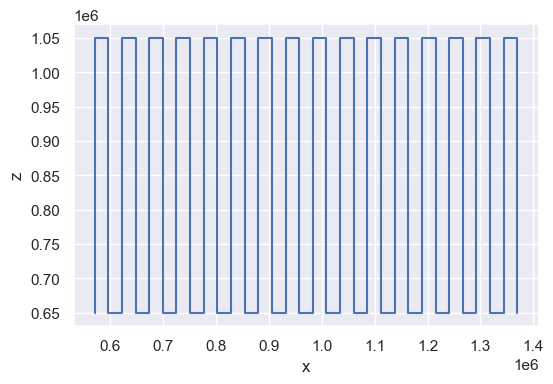

In [32]:
# show that it snakes back and forth
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
cols_arr_nm = np.array(cols_nm)
plot_cols = cols_arr_nm[:, :, [0, 2]].mean(axis=1)
ax.plot(plot_cols[:, 0], plot_cols[:, 1])
ax.set_xlabel("x")
ax.set_ylabel("z")

In [33]:
# from LayerPredictor
# 50 micron step
# minnie_bounds = np.array([[0.4123948235294118, 0.5628360000000001, 0.6878360000000003, 0.8278360000000005, 1.0294269090909096], [0.41233600000000004, 0.5628360000000001, 0.6878360000000003, 0.8378360000000005, 1.0428360000000008], [0.41346400000000005, 0.5749640000000003, 0.7049640000000004, 0.8399640000000004, 1.0562140000000007], [0.4105453333333334, 0.5672120000000002, 0.7022120000000003, 0.8572120000000004, 1.0647120000000005], [0.40784000000000004, 0.5443400000000002, 0.7043400000000003, 0.8643400000000004, 1.0675542857142863], [0.4024501818181819, 0.5431320000000002, 0.7031320000000003, 0.8931320000000005, 1.0677748571428578], [0.4121704615384616, 0.5381320000000002, 0.7181320000000003, 0.8481320000000004, 1.0712570000000006], [0.4193366153846154, 0.5814520000000002, 0.7164520000000003, 0.8464520000000004, 1.0559520000000007], [0.41036100000000003, 0.5522360000000002, 0.7072360000000003, 0.8222360000000004, 1.0525931428571436], [0.3976133333333334, 0.5477800000000002, 0.7077800000000003, 0.8527800000000004, 1.0669466666666674], [0.3934618181818182, 0.5427800000000002, 0.7077800000000003, 0.8627800000000004, 1.064565714285715], [0.3978282352941177, 0.5847400000000003, 0.7047400000000004, 0.8597400000000004, 1.063668571428572], [0.40224000000000004, 0.5747400000000003, 0.7047400000000004, 0.8497400000000004, 1.0592400000000006], [0.4061306666666667, 0.5799640000000001, 0.6999640000000003, 0.8499640000000004, 1.0529640000000005], [0.40829907692307693, 0.5588760000000002, 0.6988760000000003, 0.8138760000000004, 1.0397093333333338], [0.4071813333333334, 0.5453480000000002, 0.6903480000000003, 0.8153480000000004, 1.0178480000000005], [0.4019912380952381, 0.5463960000000001, 0.6763960000000002, 0.8063960000000003, 1.0145210000000007], [0.4051742222222222, 0.5304520000000001, 0.6904520000000003, 0.8154520000000003, 1.0337853333333338], [0.41067200000000004, 0.5431720000000002, 0.6981720000000002, 0.8781720000000004, 1.0473386666666673], [0.40801600000000005, 0.5755160000000001, 0.7005160000000004, 0.8505160000000005, 1.051349333333334], [0.39493907692307695, 0.5705160000000002, 0.7005160000000004, 0.8255160000000004, 1.056349333333334], [0.38451076923076927, 0.5477800000000002, 0.6927800000000003, 0.8627800000000004, 1.0622800000000006], [0.38461333333333336, 0.5527800000000002, 0.7027800000000003, 0.8577800000000004, 1.054208571428572], [0.4035207272727273, 0.5537480000000001, 0.7037480000000003, 0.8237480000000004, 1.0432480000000006], [0.3945813333333334, 0.5537480000000001, 0.6987480000000004, 0.8437480000000004, 1.039581333333334], [0.37963054545454544, 0.5666760000000002, 0.6866760000000003, 0.8516760000000004, 1.0537913846153852], [0.3795, 0.5595000000000001, 0.6895000000000002, 0.8295000000000003, 1.0532500000000005], [0.391141, 0.5605160000000002, 0.6955160000000002, 0.8305160000000005, 1.0540160000000007], [0.40566305882352943, 0.5605160000000002, 0.7005160000000004, 0.8555160000000004, 1.0523910000000005], [0.40776611764705883, 0.5549720000000001, 0.6949720000000003, 0.8749720000000004, 1.0434720000000006], [0.4036684444444445, 0.5267240000000002, 0.6917240000000002, 0.8117240000000003, 1.0275573333333339], [0.397224, 0.5217240000000001, 0.6717240000000002, 0.7967240000000004, 1.0148490000000006], [0.39196436363636367, 0.5208280000000001, 0.6708280000000002, 0.8008280000000003, 1.0083280000000006], [0.4008906666666667, 0.5217240000000001, 0.6767240000000003, 0.8317240000000004, 1.0217240000000007], [0.4055672380952381, 0.5199720000000001, 0.7099720000000003, 0.8499720000000004, 1.0344720000000005], [0.40063815384615387, 0.5542920000000002, 0.7042920000000004, 0.8492920000000004, 1.0411670000000006], [0.38635600000000003, 0.5563560000000002, 0.6913560000000003, 0.8413560000000004, 1.0463560000000007], [0.377, 0.5645000000000002, 0.6895000000000002, 0.8245000000000005, 1.0482500000000006], [0.3760422857142857, 0.5578280000000002, 0.6878280000000003, 0.8378280000000005, 1.0540780000000007], [0.3913106666666667, 0.49964400000000014, 0.6846440000000003, 0.8346440000000004, 1.0341440000000006], [0.388956, 0.4939560000000001, 0.6939560000000002, 0.8539560000000004, 1.0294560000000006], [0.37336800000000003, 0.5028680000000001, 0.6828680000000003, 0.8328680000000004, 1.0423680000000006], [0.37099200000000004, 0.5484920000000002, 0.6834920000000003, 0.8484920000000005, 1.0415475555555562], [0.38252800000000003, 0.5630280000000002, 0.6830280000000003, 0.8280280000000004, 1.0295280000000007], [0.3984446666666667, 0.5730280000000002, 0.6780280000000003, 0.8280280000000004, 1.0299030000000005], [0.3999626666666667, 0.5717960000000002, 0.6817960000000003, 0.8517960000000004, 1.0267960000000005], [0.39353600000000005, 0.5540360000000002, 0.6740360000000003, 0.8290360000000004, 1.0140360000000006], [0.3876137142857143, 0.5458280000000002, 0.6558280000000003, 0.7708280000000003, 0.9889530000000005], [0.38161723076923076, 0.5283480000000002, 0.6583480000000003, 0.7883480000000004, 0.9841813333333339], [0.3867588571428572, 0.5571160000000002, 0.6571160000000003, 0.8271160000000004, 1.0121160000000007], [0.39331688888888894, 0.5644280000000002, 0.6794280000000004, 0.8294280000000005, 1.0255643636363643], [0.3863613333333334, 0.5630280000000002, 0.6780280000000003, 0.8330280000000004, 1.0330280000000007], [0.3705986666666667, 0.5639320000000002, 0.6789320000000003, 0.8239320000000004, 1.0314320000000006], [0.361756, 0.5407560000000002, 0.6757560000000002, 0.8457560000000004, 1.0332560000000006], [0.3635236923076923, 0.5287160000000002, 0.6787160000000003, 0.8537160000000005, 1.0302160000000007], [0.38288457142857146, 0.5289560000000002, 0.6939560000000002, 0.8339560000000004, 1.0153448888888896], [0.3832106666666667, 0.5240440000000002, 0.6890440000000003, 0.8290440000000004, 1.0075440000000007], [0.359341, 0.48871600000000015, 0.6887160000000003, 0.8537160000000005, 1.024549333333334], [0.363756, 0.5157560000000001, 0.6707560000000004, 0.8407560000000005, 1.0317560000000006], [0.3697653333333334, 0.5339320000000002, 0.6789320000000003, 0.8289320000000004, 1.0326820000000005], [0.37977200000000005, 0.5447720000000003, 0.6747720000000004, 0.8297720000000004, 1.0289386666666673], [0.3894942222222223, 0.5147720000000002, 0.6797720000000003, 0.8297720000000004, 1.018700571428572], [0.38231576470588235, 0.4804040000000001, 0.6654040000000003, 0.7954040000000004, 1.0000468571428576], [0.373848, 0.5283480000000002, 0.6433480000000003, 0.7833480000000004, 0.9791813333333339], [0.36908, 0.5165800000000002, 0.6415800000000003, 0.7765800000000004, 0.9665800000000005], [0.3782165, 0.5154040000000002, 0.6454040000000003, 0.8104040000000003, 0.9879040000000006], [0.3815027692307693, 0.5097720000000001, 0.6597720000000002, 0.8397720000000004, 1.0062720000000005], [0.37870800000000004, 0.5247080000000002, 0.6597080000000003, 0.8647080000000005, 1.0227080000000006], [0.37448228571428577, 0.5162680000000002, 0.6612680000000003, 0.8462680000000005, 1.0267680000000006], [0.36432355555555557, 0.5012680000000002, 0.6662680000000003, 0.8312680000000005, 1.0273394285714292], [0.3622434285714286, 0.5011720000000002, 0.6761720000000003, 0.8261720000000005, 1.0175608888888896], [0.3870053333333334, 0.5011720000000002, 0.6811720000000003, 0.8361720000000005, 1.0015291428571436], [0.3765291428571429, 0.47117200000000015, 0.6711720000000003, 0.8261720000000005, 1.0020053333333339], [0.36617200000000005, 0.49117200000000016, 0.6661720000000003, 0.8111720000000004, 1.0136720000000006], [0.36753155555555556, 0.5044760000000001, 0.6644760000000003, 0.7994760000000004, 1.0229760000000006], [0.3756123636363637, 0.49947600000000014, 0.6644760000000003, 0.7994760000000004, 1.0186426666666673], [0.38183911111111113, 0.4982280000000001, 0.6582280000000003, 0.8332280000000004, 1.0169780000000006], [0.390228, 0.4682280000000001, 0.6582280000000003, 0.8282280000000004, 1.005172444444445], [0.3802221538461539, 0.5088760000000001, 0.6388760000000002, 0.8088760000000004, 0.9813760000000006], [0.36824666666666667, 0.5165800000000002, 0.6315800000000003, 0.7715800000000004, 0.9547942857142863], [0.37083314285714286, 0.4804760000000001, 0.6254760000000003, 0.7854760000000004, 0.9529760000000005], [0.3843396363636364, 0.5054760000000001, 0.6304760000000003, 0.8054760000000004, 0.9754760000000006], [0.3978791111111112, 0.5142680000000002, 0.6542680000000003, 0.8242680000000004, 0.9955180000000006], [0.38968466666666673, 0.49926800000000016, 0.6592680000000003, 0.8292680000000004, 1.0030180000000006], [0.3811658181818182, 0.5004840000000002, 0.6454840000000003, 0.8304840000000004, 1.0117340000000006], [0.3675880000000001, 0.5175880000000002, 0.6425880000000004, 0.8275880000000004, 1.0160880000000008], [0.3650880000000001, 0.4825880000000002, 0.6375880000000003, 0.8275880000000004, 1.0090880000000007], [0.37945244444444454, 0.48250800000000016, 0.6375080000000003, 0.8225080000000005, 1.0033413333333339], [0.37995200000000007, 0.48245200000000016, 0.6174520000000003, 0.8324520000000004, 0.9999520000000006], [0.3610880000000001, 0.5075880000000002, 0.6225880000000004, 0.8275880000000004, 1.018421333333334], [0.3600880000000001, 0.5225880000000003, 0.6325880000000004, 0.8025880000000005, 1.0129451428571434], [0.38045818181818186, 0.5061400000000001, 0.6411400000000003, 0.8011400000000004, 1.0036400000000005], [0.3918218181818182, 0.5011400000000001, 0.6561400000000003, 0.7861400000000004, 1.0023900000000006], [0.39605371428571434, 0.49926800000000016, 0.6392680000000003, 0.8142680000000004, 0.9905180000000007], [0.38678333333333337, 0.5097000000000002, 0.6297000000000003, 0.7847000000000004, 0.9622000000000006], [0.38353600000000004, 0.5100360000000002, 0.6200360000000003, 0.8000360000000004, 0.948369333333334], [0.3919804444444445, 0.5150360000000002, 0.6150360000000002, 0.7600360000000004, 0.9415360000000005], [0.399901090909091, 0.5114920000000002, 0.6364920000000003, 0.7764920000000004, 0.9609920000000005], [0.39788700000000005, 0.5360120000000002, 0.6260120000000002, 0.8110120000000004, 0.9877977142857148], [0.39214000000000004, 0.5111400000000001, 0.6411400000000003, 0.7811400000000004, 1.0006400000000006], [0.3819733333333334, 0.49614000000000014, 0.6361400000000003, 0.7861400000000004, 0.9967650000000006], [0.3705813333333334, 0.5097480000000001, 0.6247480000000003, 0.7997480000000003, 1.013081333333334], [0.36299600000000004, 0.49199600000000016, 0.6319960000000002, 0.7969960000000005, 1.0188710000000007], [0.36995200000000006, 0.49245200000000017, 0.6324520000000002, 0.7874520000000005, 1.0049520000000007], [0.36212200000000005, 0.5033720000000002, 0.6133720000000003, 0.8083720000000005, 1.0042053333333338], [0.3667182222222223, 0.5019960000000001, 0.6119960000000002, 0.7919960000000004, 1.0176210000000006], [0.37494030769230774, 0.4797480000000001, 0.6197480000000002, 0.7897480000000003, 0.9989146666666673], [0.38602800000000004, 0.49702800000000014, 0.6320280000000003, 0.7870280000000004, 0.9970280000000006], [0.390668, 0.5406680000000001, 0.6256680000000002, 0.8156680000000004, 0.9931680000000005], [0.39992000000000005, 0.5344200000000001, 0.6244200000000002, 0.8194200000000005, 0.9769200000000006], [0.4027533333333334, 0.5144200000000001, 0.6244200000000002, 0.7794200000000004, 0.9600450000000006], [0.40198030769230775, 0.5167880000000001, 0.6067880000000002, 0.7617880000000004, 0.9365102222222227], [0.4162106666666667, 0.5170440000000001, 0.6120440000000003, 0.7420440000000004, 0.9355440000000005], [0.40384307692307697, 0.5194200000000002, 0.6244200000000002, 0.7744200000000003, 0.9560866666666672], [0.3945549090909091, 0.5029640000000002, 0.6279640000000002, 0.7829640000000004, 0.9796306666666672], [0.38764400000000004, 0.5226440000000001, 0.6226440000000002, 0.7876440000000005, 0.9863940000000005], [0.3820763636363637, 0.48594000000000015, 0.6159400000000003, 0.7859400000000004, 1.0024400000000007], [0.3680633846153847, 0.46094800000000014, 0.6159480000000003, 0.7809480000000004, 1.0059480000000005], [0.3660036363636364, 0.4921400000000002, 0.6121400000000004, 0.7871400000000004, 1.0096400000000005], [0.36170533333333343, 0.5033720000000002, 0.6033720000000002, 0.8283720000000006, 1.0042053333333338], [0.3494426666666667, 0.5002760000000002, 0.6052760000000003, 0.8302760000000005, 0.996109333333334], [0.36023200000000005, 0.48773200000000017, 0.6027320000000003, 0.7877320000000004, 1.0042320000000007], [0.35932290909090914, 0.48273200000000016, 0.6127320000000003, 0.7927320000000004, 1.0012320000000006], [0.36928888888888894, 0.5029000000000001, 0.6079000000000003, 0.7929000000000004, 0.9970666666666673], [0.383464, 0.5179640000000001, 0.6029640000000003, 0.7979640000000003, 0.9879640000000005], [0.39021600000000006, 0.5077160000000002, 0.6027160000000003, 0.8027160000000004, 0.9789660000000007], [0.40126200000000006, 0.5200120000000001, 0.6150120000000002, 0.7650120000000004, 0.9587620000000006], [0.4053691428571429, 0.5250120000000001, 0.6150120000000002, 0.7300120000000003, 0.9375120000000006]])
# 25 micron step
minnie_bounds = np.asarray([[0.4123948235294118, 0.5628360000000001, 0.6878360000000003, 0.8278360000000005, 1.0294269090909096], [0.41319314285714287, 0.5628360000000001, 0.6878360000000003, 0.8228360000000003, 1.0383360000000006], [0.41390742857142865, 0.5678360000000002, 0.6878360000000003, 0.8378360000000005, 1.0428360000000005], [0.41246400000000005, 0.5749640000000003, 0.6999640000000003, 0.8349640000000005, 1.0512140000000005], [0.4129185454545455, 0.5749640000000003, 0.7049640000000004, 0.8349640000000005, 1.055797333333334], [0.41155490909090914, 0.5699640000000001, 0.7149640000000004, 0.8499640000000004, 1.0562140000000007], [0.4119847272727273, 0.5672120000000002, 0.7022120000000003, 0.8572120000000004, 1.0609620000000006], [0.41122800000000004, 0.5702280000000002, 0.7002280000000003, 0.8552280000000004, 1.0647280000000006], [0.4096177777777778, 0.5643400000000002, 0.6993400000000003, 0.8643400000000004, 1.0653400000000006], [0.4051733333333334, 0.5643400000000002, 0.7043400000000003, 0.8893400000000005, 1.0674650000000008], [0.40255428571428575, 0.5643400000000002, 0.7043400000000003, 0.8893400000000005, 1.0693400000000006], [0.4018820000000001, 0.5631320000000002, 0.7081320000000003, 0.8781320000000005, 1.0712570000000006], [0.4043820000000001, 0.5681320000000002, 0.7081320000000003, 0.8481320000000004, 1.0713462857142864], [0.41313200000000005, 0.5681320000000002, 0.7181320000000003, 0.8481320000000004, 1.0725070000000008], [0.41413200000000006, 0.5681320000000002, 0.7181320000000003, 0.8481320000000004, 1.0706320000000007], [0.4193366153846154, 0.5814520000000002, 0.7164520000000003, 0.8464520000000004, 1.0559520000000007], [0.41495200000000004, 0.5714520000000002, 0.7114520000000003, 0.8314520000000004, 1.0581186666666673], [0.41149600000000003, 0.5679960000000002, 0.7129960000000003, 0.8479960000000004, 1.0711210000000007], [0.4086355555555556, 0.5605800000000002, 0.7055800000000003, 0.8505800000000004, 1.0730800000000007], [0.39808000000000004, 0.5705800000000002, 0.7055800000000003, 0.8505800000000004, 1.0709371428571435], [0.39808000000000004, 0.5655800000000002, 0.7055800000000003, 0.8655800000000005, 1.0716514285714291], [0.39860631578947375, 0.5655800000000002, 0.7105800000000003, 0.8655800000000005, 1.0709371428571435], [0.40011284210526316, 0.5828760000000002, 0.7078760000000003, 0.8628760000000004, 1.0660902857142862], [0.40104266666666666, 0.5778760000000002, 0.7078760000000003, 0.8578760000000004, 1.0653760000000005], [0.40394742857142857, 0.5728760000000002, 0.7078760000000003, 0.8578760000000004, 1.0645426666666673], [0.40346200000000004, 0.5672120000000002, 0.7072120000000003, 0.8572120000000004, 1.0615870000000007], [0.4061003636363637, 0.5749640000000003, 0.7149640000000004, 0.8499640000000004, 1.0555890000000006], [0.4085188571428572, 0.5788760000000002, 0.7038760000000003, 0.8438760000000004, 1.0543760000000006], [0.4081617142857143, 0.5738760000000002, 0.7038760000000003, 0.8388760000000004, 1.0452648888888896], [0.41099138461538465, 0.5588760000000002, 0.6988760000000003, 0.8338760000000004, 1.0395010000000005], [0.4098375384615385, 0.5638760000000002, 0.6938760000000003, 0.8138760000000004, 1.0330426666666672], [0.4095146666666667, 0.5653480000000002, 0.6903480000000003, 0.8203480000000004, 1.0253480000000006], [0.4071813333333334, 0.5503480000000002, 0.6903480000000003, 0.8153480000000004, 1.0178480000000005], [0.40679266666666664, 0.5388760000000001, 0.6888760000000003, 0.8188760000000004, 1.0335188571428577], [0.40762600000000004, 0.5638760000000002, 0.7038760000000003, 0.8138760000000004, 1.0406617142857149], [0.40604266666666666, 0.5588760000000002, 0.7038760000000003, 0.8138760000000004, 1.0458760000000007], [0.40575100000000003, 0.5838760000000002, 0.7038760000000003, 0.8488760000000004, 1.052804571428572], [0.40454733333333337, 0.5749640000000003, 0.7049640000000004, 0.8549640000000005, 1.0535751111111116], [0.40324000000000004, 0.5747400000000003, 0.7147400000000004, 0.8497400000000004, 1.0572400000000006], [0.40416307692307696, 0.5747400000000003, 0.7147400000000004, 0.8497400000000004, 1.0597400000000006], [0.4006775, 0.5847400000000003, 0.7047400000000004, 0.8597400000000004, 1.063073333333334], [0.39824000000000004, 0.5847400000000003, 0.6997400000000003, 0.8597400000000004, 1.0647400000000005], [0.3961434285714286, 0.5825720000000002, 0.6975720000000003, 0.8725720000000005, 1.0650720000000007], [0.39536611764705887, 0.5825720000000002, 0.7075720000000003, 0.8625720000000004, 1.0650720000000007], [0.39507200000000003, 0.5475720000000002, 0.7075720000000003, 0.8475720000000004, 1.0644470000000006], [0.3987386666666667, 0.5575720000000002, 0.7075720000000003, 0.8525720000000004, 1.0663220000000007], [0.4014026666666667, 0.5572360000000002, 0.7072360000000003, 0.8522360000000004, 1.0639026666666673], [0.40973600000000004, 0.5522360000000002, 0.7072360000000003, 0.8472360000000004, 1.0525931428571436], [0.4033426666666667, 0.5516760000000002, 0.7016760000000003, 0.8216760000000004, 1.0466760000000006], [0.3975093333333334, 0.5516760000000002, 0.7066760000000003, 0.8516760000000004, 1.0571760000000006], [0.39209818181818185, 0.5577800000000002, 0.7077800000000003, 0.8577800000000004, 1.0602800000000006], [0.3884618181818182, 0.5477800000000002, 0.7077800000000003, 0.8627800000000004, 1.0622800000000006], [0.3884618181818182, 0.5427800000000002, 0.7027800000000003, 0.8677800000000004, 1.0627800000000005], [0.3893027692307693, 0.5725720000000002, 0.7025720000000003, 0.8775720000000005, 1.0630720000000007], [0.39416307692307695, 0.5797400000000001, 0.6997400000000003, 0.8597400000000004, 1.0615257142857148], [0.3988189473684211, 0.5697400000000001, 0.7047400000000004, 0.8597400000000004, 1.0550971428571436], [0.40224000000000004, 0.5697400000000001, 0.7047400000000004, 0.8547400000000005, 1.0526945454545462], [0.4059900000000001, 0.5647400000000002, 0.7147400000000004, 0.8547400000000005, 1.0522400000000007], [0.40837309090909096, 0.5599640000000001, 0.7099640000000003, 0.8799640000000004, 1.0528211428571435], [0.40804266666666666, 0.5638760000000002, 0.7038760000000003, 0.8738760000000004, 1.0497093333333338], [0.406376, 0.5588760000000002, 0.6988760000000003, 0.8138760000000004, 1.0438760000000005], [0.40470933333333337, 0.5588760000000002, 0.6938760000000003, 0.8138760000000004, 1.035661714285715], [0.40461129411764707, 0.5288760000000001, 0.6888760000000003, 0.8088760000000004, 1.0272093333333339], [0.40384800000000004, 0.5553480000000002, 0.6853480000000003, 0.8053480000000004, 1.0161813333333338], [0.4025802105263158, 0.5563960000000001, 0.6763960000000002, 0.8063960000000003, 1.0151460000000005], [0.4036018823529412, 0.5313960000000002, 0.6763960000000002, 0.8113960000000005, 1.0228960000000007], [0.4050702222222223, 0.5303480000000002, 0.6903480000000003, 0.8153480000000004, 1.0317368888888896], [0.4061813333333334, 0.5203480000000001, 0.6953480000000003, 0.8153480000000004, 1.0398480000000005], [0.41019066666666665, 0.5785240000000001, 0.6935240000000003, 0.8735240000000004, 1.047452571428572], [0.4098866666666667, 0.5482200000000002, 0.6982200000000003, 0.8782200000000004, 1.0492914285714292], [0.40795428571428577, 0.5647400000000002, 0.7097400000000003, 0.8397400000000004, 1.0472400000000006], [0.40489100000000006, 0.5705160000000002, 0.7055160000000003, 0.8555160000000004, 1.0508731428571434], [0.3996826666666667, 0.5705160000000002, 0.7005160000000004, 0.8405160000000005, 1.0530160000000006], [0.39373028571428575, 0.5705160000000002, 0.7005160000000004, 0.8355160000000004, 1.062301714285715], [0.3862258461538462, 0.5575720000000002, 0.6925720000000003, 0.8675720000000005, 1.0642386666666672], [0.38451076923076927, 0.5477800000000002, 0.6977800000000003, 0.8627800000000004, 1.0632800000000007], [0.38236333333333333, 0.5477800000000002, 0.7027800000000003, 0.8577800000000004, 1.0644466666666674], [0.3849228571428572, 0.5577800000000002, 0.7027800000000003, 0.8527800000000004, 1.0552800000000007], [0.3903389090909091, 0.5587480000000002, 0.7037480000000003, 0.8237480000000004, 1.0531710769230775], [0.402498, 0.5537480000000001, 0.7037480000000003, 0.8237480000000004, 1.0442480000000007], [0.40215709090909096, 0.5487480000000002, 0.7037480000000003, 0.8187480000000005, 1.0387480000000004], [0.38624800000000004, 0.5637480000000001, 0.7037480000000003, 0.8287480000000005, 1.0504146666666674], [0.3822030769230769, 0.5677800000000002, 0.6977800000000003, 0.8477800000000004, 1.0531966666666672], [0.3813911111111111, 0.5577800000000002, 0.7027800000000003, 0.8327800000000004, 1.0602800000000006], [0.38255272727272727, 0.5527800000000002, 0.7027800000000003, 0.8327800000000004, 1.0562800000000006], [0.38533333333333336, 0.5595000000000001, 0.6895000000000002, 0.8345000000000005, 1.0607500000000007], [0.39161538461538464, 0.5695000000000001, 0.6945000000000003, 0.8395000000000004, 1.0620000000000007], [0.39989100000000005, 0.5705160000000002, 0.7005160000000004, 0.8305160000000005, 1.0519048888888896], [0.40520350000000005, 0.5655160000000001, 0.7005160000000004, 0.8505160000000005, 1.051587428571429], [0.4085733333333334, 0.5647400000000002, 0.6997400000000003, 0.8547400000000005, 1.0497400000000008], [0.4082614736842105, 0.5599720000000001, 0.6899720000000003, 0.8799720000000004, 1.0493470000000005], [0.40802755555555553, 0.5599720000000001, 0.6949720000000003, 0.8749720000000004, 1.0480275555555563], [0.4062658823529412, 0.5340600000000002, 0.6890600000000002, 0.8140600000000004, 1.0398933333333338], [0.40406000000000003, 0.5290600000000001, 0.6890600000000002, 0.8140600000000004, 1.0301314285714291], [0.4025802105263158, 0.5263960000000001, 0.6763960000000002, 0.8163960000000003, 1.0216232727272734], [0.4004806956521739, 0.5553720000000002, 0.6753720000000003, 0.8053720000000004, 1.0128720000000007], [0.3985573333333334, 0.5217240000000001, 0.6717240000000002, 0.7967240000000004, 1.0142240000000005], [0.402224, 0.5217240000000001, 0.6717240000000002, 0.8067240000000004, 1.020762461538462], [0.404224, 0.5217240000000001, 0.6717240000000002, 0.8117240000000003, 1.0238668571428577], [0.40599799999999997, 0.5287480000000001, 0.6937480000000003, 0.8137480000000004, 1.0341051428571435], [0.40699580952380954, 0.5549720000000001, 0.6949720000000003, 0.8349720000000004, 1.0449720000000005], [0.40641936842105264, 0.5599720000000001, 0.6899720000000003, 0.8799720000000004, 1.0481862857142863], [0.40679200000000004, 0.5642920000000002, 0.6992920000000002, 0.8442920000000005, 1.0497920000000007], [0.4023017142857143, 0.5605160000000002, 0.7005160000000004, 0.8605160000000005, 1.0519048888888896], [0.3963493333333334, 0.5605160000000002, 0.7005160000000004, 0.8405160000000005, 1.0525614545454551], [0.388, 0.5645000000000002, 0.6945000000000003, 0.8345000000000005, 1.0570000000000006], [0.382, 0.5595000000000001, 0.6895000000000002, 0.8295000000000003, 1.055333333333334], [0.3796470588235294, 0.5595000000000001, 0.6895000000000002, 0.8295000000000003, 1.0510625000000005], [0.37825, 0.5595000000000001, 0.6895000000000002, 0.8495000000000004, 1.0557500000000006], [0.381176, 0.5666760000000002, 0.6866760000000003, 0.8466760000000004, 1.0506760000000006], [0.3845813333333334, 0.5637480000000001, 0.6887480000000004, 0.8487480000000005, 1.047676571428572], [0.3991051428571429, 0.5487480000000002, 0.6987480000000004, 0.8487480000000005, 1.0362480000000005], [0.3920813333333334, 0.5487480000000002, 0.6987480000000004, 0.8337480000000004, 1.0345813333333338], [0.38215709090909095, 0.5537480000000001, 0.6837480000000002, 0.8437480000000004, 1.0472480000000006], [0.3764391111111111, 0.5628280000000001, 0.6878280000000003, 0.8478280000000005, 1.0497030000000005], [0.3755, 0.5595000000000001, 0.6895000000000002, 0.8345000000000005, 1.0595000000000008], [0.3777142857142857, 0.5645000000000002, 0.6895000000000002, 0.8295000000000003, 1.0499166666666673], [0.381, 0.5645000000000002, 0.6895000000000002, 0.8295000000000003, 1.0545000000000004], [0.38825, 0.5595000000000001, 0.6945000000000003, 0.8345000000000005, 1.0520000000000005], [0.39493907692307695, 0.5555160000000001, 0.7005160000000004, 0.8355160000000004, 1.0505160000000004], [0.4010929230769231, 0.5555160000000001, 0.7005160000000004, 0.8405160000000005, 1.0511410000000005], [0.4052295, 0.5642920000000002, 0.6992920000000002, 0.8342920000000005, 1.0484586666666673], [0.40532914285714283, 0.5599720000000001, 0.6899720000000003, 0.8649720000000004, 1.0441386666666672], [0.4059502608695652, 0.5499720000000001, 0.6949720000000003, 0.8299720000000004, 1.0394720000000006], [0.40562023529411767, 0.5325320000000001, 0.6925320000000003, 0.8175320000000004, 1.0323396923076928], [0.4020811428571429, 0.5217240000000001, 0.6917240000000002, 0.8117240000000003, 1.0242240000000007], [0.399328, 0.5158280000000002, 0.6758280000000003, 0.8108280000000003, 1.0192370909090915], [0.395828, 0.5158280000000002, 0.6758280000000003, 0.7958280000000004, 1.0126137142857148], [0.39196436363636367, 0.5158280000000002, 0.6708280000000002, 0.8008280000000003, 1.0083280000000006], [0.3966613333333333, 0.5158280000000002, 0.6758280000000003, 0.8208280000000003, 1.0149946666666672], [0.39993828571428575, 0.5217240000000001, 0.6867240000000003, 0.8267240000000005, 1.0211470769230775], [0.40369866666666665, 0.5325320000000001, 0.6925320000000003, 0.8275320000000004, 1.0275320000000006], [0.40383563636363634, 0.5499720000000001, 0.7099720000000003, 0.8299720000000004, 1.0319164444444449], [0.4036484705882353, 0.5599720000000001, 0.6999720000000003, 0.8649720000000004, 1.0399720000000006], [0.4014978823529412, 0.5592920000000001, 0.7042920000000004, 0.8442920000000005, 1.0442920000000004], [0.39579200000000003, 0.5542920000000002, 0.7042920000000004, 0.8442920000000005, 1.0480420000000006], [0.3902535384615385, 0.5492920000000001, 0.7042920000000004, 0.8392920000000004, 1.0492920000000008], [0.38533333333333336, 0.5595000000000001, 0.6945000000000003, 0.8395000000000004, 1.0470000000000006], [0.3795, 0.5595000000000001, 0.6895000000000002, 0.8295000000000003, 1.0512857142857148], [0.37533333333333335, 0.5645000000000002, 0.6845000000000003, 0.8295000000000003, 1.0498571428571435], [0.37422222222222223, 0.5645000000000002, 0.6895000000000002, 0.8345000000000005, 1.0512857142857148], [0.37699466666666664, 0.5528280000000001, 0.6878280000000003, 0.8428280000000004, 1.0515780000000006], [0.38214400000000004, 0.49464400000000014, 0.6896440000000004, 0.8446440000000004, 1.0481440000000006], [0.39214400000000005, 0.5296440000000002, 0.6896440000000004, 0.8346440000000004, 1.0341440000000006], [0.389008, 0.5315080000000001, 0.6915080000000002, 0.8365080000000005, 1.0290080000000006], [0.383172, 0.4931720000000001, 0.6881720000000002, 0.8331720000000005, 1.0431720000000007], [0.37852914285714284, 0.5081720000000001, 0.6881720000000002, 0.8331720000000005, 1.0481720000000005], [0.37483866666666665, 0.5631720000000002, 0.6831720000000003, 0.8481720000000004, 1.0523386666666672], [0.37416971428571427, 0.5598840000000002, 0.6848840000000003, 0.8498840000000004, 1.0513840000000005], [0.37595542857142855, 0.5548840000000002, 0.6898840000000003, 0.8298840000000004, 1.0493840000000005], [0.3824923636363637, 0.5563560000000002, 0.6863560000000003, 0.8413560000000004, 1.0449671111111116], [0.389292, 0.5492920000000001, 0.6842920000000003, 0.8442920000000005, 1.0447920000000006], [0.39563815384615386, 0.5642920000000002, 0.6792920000000002, 0.8642920000000005, 1.0403634285714292], [0.40000628571428576, 0.5642920000000002, 0.6842920000000003, 0.8542920000000005, 1.0374170000000005], [0.4041378461538462, 0.5654840000000001, 0.6854840000000002, 0.8654840000000004, 1.032529454545455], [0.4030311111111112, 0.5694200000000003, 0.6844200000000003, 0.8544200000000004, 1.0285866666666672], [0.403378105263158, 0.5790360000000002, 0.6790360000000003, 0.8540360000000005, 1.0232026666666674], [0.39903600000000006, 0.5490360000000002, 0.6740360000000003, 0.8290360000000004, 1.020107428571429], [0.3957026666666667, 0.5090360000000002, 0.6740360000000003, 0.8190360000000004, 1.0135360000000007], [0.391328, 0.5358280000000002, 0.6708280000000002, 0.8108280000000003, 1.0008280000000007], [0.389828, 0.5108280000000001, 0.6708280000000002, 0.7908280000000003, 0.9904708571428577], [0.3911193333333334, 0.4740360000000001, 0.6740360000000003, 0.8190360000000004, 1.0065360000000005], [0.3948693333333334, 0.49903600000000015, 0.6740360000000003, 0.8290360000000004, 1.0165360000000006], [0.3980744615384616, 0.4740360000000001, 0.6740360000000003, 0.8490360000000005, 1.0205360000000006], [0.39942000000000005, 0.5044200000000001, 0.6744200000000002, 0.8544200000000004, 1.0260109090909095], [0.4003674285714286, 0.5667960000000002, 0.7017960000000003, 0.8467960000000004, 1.0297960000000006], [0.39702800000000005, 0.5530280000000002, 0.6980280000000003, 0.8530280000000005, 1.0295280000000007], [0.39252800000000004, 0.5530280000000002, 0.6980280000000003, 0.8330280000000004, 1.0321946666666673], [0.3884446666666667, 0.5480280000000002, 0.6830280000000003, 0.8280280000000004, 1.0355280000000007], [0.38011133333333336, 0.5630280000000002, 0.6830280000000003, 0.8480280000000004, 1.0321946666666673], [0.37299200000000005, 0.5534920000000002, 0.6834920000000003, 0.8484920000000005, 1.0409920000000006], [0.37229107692307695, 0.5578680000000003, 0.6828680000000003, 0.8478680000000005, 1.0422430000000007], [0.3740043636363637, 0.5428680000000001, 0.6878680000000004, 0.8228680000000004, 1.0420346666666673], [0.3767965714285715, 0.5278680000000002, 0.6778680000000004, 0.8278680000000005, 1.0423680000000006], [0.381618, 0.5278680000000002, 0.6828680000000003, 0.8528680000000004, 1.0346537142857148], [0.388956, 0.5239560000000001, 0.6889560000000003, 0.8439560000000004, 1.0304560000000005], [0.38812266666666667, 0.5239560000000001, 0.6939560000000002, 0.8639560000000004, 1.0247893333333338], [0.37871600000000005, 0.5287160000000002, 0.6787160000000003, 0.8587160000000005, 1.034549333333334], [0.3720493333333334, 0.5287160000000002, 0.6787160000000003, 0.8337160000000005, 1.0412160000000006], [0.36621600000000004, 0.5637160000000002, 0.6737160000000003, 0.8487160000000005, 1.0420493333333338], [0.36443050000000005, 0.5628680000000001, 0.6728680000000002, 0.8478680000000005, 1.0423680000000006], [0.36755450000000006, 0.5534920000000002, 0.6834920000000003, 0.8434920000000005, 1.0322420000000005], [0.37240300000000004, 0.5630280000000002, 0.6830280000000003, 0.8480280000000004, 1.0305280000000006], [0.3821946666666667, 0.5480280000000002, 0.6830280000000003, 0.8180280000000004, 1.0305280000000006], [0.3888613333333334, 0.5630280000000002, 0.6830280000000003, 0.8180280000000004, 1.0299030000000005], [0.3950734545454546, 0.5630280000000002, 0.6830280000000003, 0.8530280000000005, 1.0317780000000005], [0.3977575384615385, 0.5717960000000002, 0.6817960000000003, 0.8367960000000004, 1.0292960000000007], [0.39692000000000005, 0.5694200000000003, 0.6794200000000004, 0.8394200000000005, 1.0255563636363643], [0.39453600000000005, 0.5640360000000002, 0.6740360000000003, 0.8390360000000004, 1.0202860000000007], [0.3896160000000001, 0.5571160000000002, 0.6721160000000003, 0.8321160000000004, 1.0116160000000005], [0.3859493333333333, 0.5521160000000002, 0.6721160000000003, 0.8171160000000004, 1.001044571428572], [0.384616, 0.5121160000000001, 0.6571160000000003, 0.7771160000000004, 0.9879493333333339], [0.38195911111111114, 0.5283480000000002, 0.6583480000000003, 0.7833480000000004, 0.9825146666666672], [0.38347963636363636, 0.5421160000000002, 0.6621160000000003, 0.8171160000000004, 0.9979493333333339], [0.3850326666666667, 0.5571160000000002, 0.6621160000000003, 0.8221160000000004, 1.0121160000000005], [0.38953600000000005, 0.5640360000000002, 0.6740360000000003, 0.8340360000000004, 1.0201723636363642], [0.39423569230769234, 0.5594280000000003, 0.6794280000000004, 0.8344280000000004, 1.0244280000000008], [0.3942613333333334, 0.5644280000000002, 0.6794280000000004, 0.8394280000000005, 1.0278370909090917], [0.39052800000000004, 0.5580280000000002, 0.6830280000000003, 0.8330280000000004, 1.0296946666666673], [0.38338514285714287, 0.5580280000000002, 0.6830280000000003, 0.8330280000000004, 1.0290280000000005], [0.37652800000000003, 0.5580280000000002, 0.6830280000000003, 0.8280280000000004, 1.0292780000000006], [0.368028, 0.5580280000000002, 0.6830280000000003, 0.8480280000000004, 1.0288613333333338], [0.36381155555555555, 0.5557560000000001, 0.6807560000000004, 0.8457560000000004, 1.0292560000000006], [0.363256, 0.5407560000000002, 0.6757560000000002, 0.8457560000000004, 1.0345060000000006], [0.3643978181818182, 0.5437160000000002, 0.6737160000000003, 0.8487160000000005, 1.0333588571428578], [0.36809100000000006, 0.5287160000000002, 0.6737160000000003, 0.8437160000000005, 1.0337160000000005], [0.3789937777777778, 0.5337160000000002, 0.6787160000000003, 0.8487160000000005, 1.0317160000000005], [0.38717028571428574, 0.5289560000000002, 0.6939560000000002, 0.8539560000000004, 1.0231226666666673], [0.38265511111111117, 0.5240440000000002, 0.6990440000000003, 0.8340440000000005, 1.012972571428572], [0.36821600000000004, 0.49871600000000016, 0.6837160000000003, 0.8387160000000005, 1.0262160000000007], [0.36246600000000007, 0.5037160000000002, 0.6737160000000003, 0.8537160000000005, 1.0287160000000006], [0.35907314285714287, 0.5237160000000002, 0.6787160000000003, 0.8537160000000005, 1.0312160000000006], [0.3615893333333334, 0.5157560000000001, 0.6857560000000003, 0.8357560000000004, 1.0302560000000007], [0.363256, 0.5407560000000002, 0.6857560000000003, 0.8157560000000004, 1.0312560000000006], [0.3656627692307693, 0.5489320000000002, 0.6839320000000003, 0.8289320000000004, 1.0294320000000006], [0.3694337142857143, 0.5451480000000002, 0.6801480000000003, 0.8301480000000004, 1.0312194285714291], [0.37514800000000004, 0.5501480000000002, 0.6801480000000003, 0.8301480000000004, 1.0297908571428578], [0.38764800000000005, 0.5501480000000002, 0.6851480000000003, 0.8301480000000004, 1.0296480000000006], [0.39130300000000007, 0.5594280000000003, 0.6894280000000004, 0.8294280000000005, 1.0258168888888897], [0.39101890909090914, 0.5544280000000001, 0.6794280000000004, 0.8294280000000005, 1.0219280000000006], [0.3876098823529412, 0.5554040000000002, 0.6704040000000002, 0.8304040000000004, 1.0154040000000006], [0.3857165, 0.5554040000000002, 0.6554040000000003, 0.8154040000000005, 1.0029040000000005], [0.38157066666666667, 0.5404040000000001, 0.6554040000000003, 0.8154040000000005, 0.9919040000000006], [0.3779908571428572, 0.5283480000000002, 0.6533480000000003, 0.7883480000000004, 0.9808480000000006], [0.37467152941176474, 0.5383480000000002, 0.6383480000000002, 0.7883480000000004, 0.9775146666666672], [0.376904, 0.5404040000000001, 0.6504040000000002, 0.8054040000000005, 0.9945706666666673], [0.3825706666666667, 0.5404040000000001, 0.6554040000000003, 0.8054040000000005, 1.0022790000000004], [0.38606164705882356, 0.5444440000000002, 0.6644440000000003, 0.8294440000000004, 1.0126582857142863], [0.38967127272727275, 0.5344440000000001, 0.6794440000000003, 0.8294440000000004, 1.020515428571429], [0.38770400000000005, 0.5272040000000002, 0.6772040000000004, 0.8322040000000004, 1.0222040000000008], [0.3834540000000001, 0.5422040000000001, 0.6772040000000004, 0.8322040000000004, 1.0297040000000006], [0.3739347692307693, 0.5472040000000002, 0.6722040000000002, 0.8322040000000004, 1.0297040000000006], [0.3711095384615385, 0.5451480000000002, 0.6751480000000003, 0.8301480000000004, 1.0326480000000007], [0.3660986666666667, 0.5439320000000002, 0.6739320000000003, 0.8289320000000004, 1.0314320000000006], [0.36392266666666667, 0.5157560000000001, 0.6707560000000004, 0.8407560000000005, 1.0303988571428577], [0.35992266666666667, 0.5157560000000001, 0.6707560000000004, 0.8407560000000005, 1.0312560000000006], [0.35921600000000004, 0.5037160000000002, 0.6687160000000003, 0.8437160000000005, 1.0312160000000006], [0.361841, 0.5037160000000002, 0.6737160000000003, 0.8537160000000005, 1.0262160000000007], [0.37184100000000003, 0.5237160000000002, 0.6787160000000003, 0.8437160000000005, 1.0233588571428578], [0.38582971428571433, 0.5440440000000002, 0.6840440000000003, 0.8390440000000005, 1.0052940000000006], [0.38654400000000005, 0.5240440000000002, 0.6790440000000003, 0.8390440000000005, 1.0052940000000006], [0.36249600000000004, 0.5249960000000002, 0.6699960000000003, 0.8449960000000005, 1.0154960000000006], [0.3610674285714286, 0.5249960000000002, 0.6699960000000003, 0.8449960000000005, 1.0174960000000006], [0.3577004444444445, 0.5157560000000001, 0.6707560000000004, 0.8407560000000005, 1.0292560000000006], [0.358256, 0.5257560000000001, 0.6657560000000002, 0.8407560000000005, 1.0297560000000008], [0.36436711111111114, 0.5207560000000002, 0.6657560000000002, 0.8407560000000005, 1.0317560000000006], [0.3679346666666667, 0.5462680000000002, 0.6712680000000003, 0.8162680000000004, 1.0312680000000007], [0.3722055, 0.5462680000000002, 0.6612680000000003, 0.8312680000000005, 1.0312680000000007], [0.37470800000000004, 0.5447080000000002, 0.6647080000000003, 0.8297080000000004, 1.0279222857142862], [0.38292228571428577, 0.5347080000000002, 0.6647080000000003, 0.8297080000000004, 1.0253330000000007], [0.3868553333333334, 0.5247720000000002, 0.6647720000000004, 0.8447720000000005, 1.0194148571428576], [0.3861181538461539, 0.5147720000000002, 0.6647720000000004, 0.8397720000000004, 1.016557714285715], [0.3845910588235294, 0.4794440000000001, 0.6594440000000003, 0.8294440000000004, 1.0069440000000005], [0.38085466666666673, 0.5391880000000002, 0.6491880000000003, 0.8041880000000003, 0.9979380000000005], [0.375438, 0.5291880000000002, 0.6441880000000002, 0.8091880000000005, 0.9891880000000006], [0.3728418461538462, 0.5291880000000002, 0.6391880000000003, 0.7991880000000005, 0.9716880000000006], [0.3723347692307693, 0.5156040000000002, 0.6356040000000003, 0.7856040000000004, 0.9756040000000005], [0.3724572307692308, 0.5091880000000002, 0.6391880000000003, 0.8091880000000005, 0.9858546666666672], [0.3796291764705883, 0.49918800000000013, 0.6541880000000002, 0.7941880000000003, 0.9941880000000005], [0.38494400000000006, 0.4994440000000001, 0.6594440000000003, 0.8194440000000004, 1.0029440000000005], [0.3847720000000001, 0.5047720000000002, 0.6647720000000004, 0.8397720000000004, 1.0110220000000008], [0.3844942222222223, 0.5297720000000001, 0.6597720000000002, 0.8497720000000004, 1.0178970000000005], [0.3790261818181819, 0.5397080000000002, 0.6597080000000003, 0.8397080000000005, 1.023571636363637], [0.3716197647058824, 0.5447080000000002, 0.6597080000000003, 0.8447080000000005, 1.0244807272727279], [0.3711013333333334, 0.5412680000000002, 0.6612680000000003, 0.8262680000000004, 1.0265457777777784], [0.3683134545454546, 0.5462680000000002, 0.6612680000000003, 0.8262680000000004, 1.0265457777777784], [0.36476800000000004, 0.5012680000000002, 0.6712680000000003, 0.8262680000000004, 1.0259108571428577], [0.35838338461538466, 0.5012680000000002, 0.6712680000000003, 0.8312680000000005, 1.024601333333334], [0.3561720000000001, 0.5011720000000002, 0.6761720000000003, 0.8311720000000005, 1.025100571428572], [0.3570053333333334, 0.49617200000000017, 0.6761720000000003, 0.8411720000000005, 1.0186720000000007], [0.36033866666666675, 0.49617200000000017, 0.6761720000000003, 0.8361720000000005, 1.0174220000000007], [0.38700533333333353, 0.5061720000000002, 0.6811720000000003, 0.8361720000000005, 1.0093862857142863], [0.3886720000000001, 0.5011720000000002, 0.6861720000000003, 0.8311720000000005, 1.0061720000000007], [0.36867200000000006, 0.5011720000000002, 0.6811720000000003, 0.8361720000000005, 1.0115291428571436], [0.36304700000000006, 0.49117200000000016, 0.6761720000000003, 0.8261720000000005, 1.0186720000000007], [0.36304700000000006, 0.5061720000000002, 0.6761720000000003, 0.7911720000000004, 1.0253386666666673], [0.36155933333333334, 0.49947600000000014, 0.6744760000000003, 0.8144760000000004, 1.0253093333333338], [0.36572600000000005, 0.49947600000000014, 0.6644760000000003, 0.8144760000000004, 1.026420444444445], [0.37097600000000003, 0.49947600000000014, 0.6644760000000003, 0.8144760000000004, 1.0251578181818188], [0.37747600000000003, 0.49947600000000014, 0.6644760000000003, 0.8144760000000004, 1.020309333333334], [0.37720800000000004, 0.5247080000000002, 0.6597080000000003, 0.8597080000000005, 1.0184580000000005], [0.3809580000000001, 0.5297080000000002, 0.6597080000000003, 0.8397080000000005, 1.0190261818181825], [0.38477200000000006, 0.5297720000000001, 0.6597720000000002, 0.8297720000000004, 1.010605333333334], [0.3831053333333334, 0.5097720000000001, 0.6547720000000004, 0.8397720000000004, 1.005843428571429], [0.38277733333333336, 0.5094440000000001, 0.6544440000000002, 0.8194440000000004, 0.9969440000000005], [0.37887600000000005, 0.5188760000000001, 0.6388760000000002, 0.8138760000000005, 0.9876260000000006], [0.37466823529411764, 0.5165800000000002, 0.6365800000000003, 0.7815800000000004, 0.9765800000000006], [0.3724133333333334, 0.5215800000000002, 0.6315800000000003, 0.7765800000000004, 0.9657466666666672], [0.36796888888888885, 0.5165800000000002, 0.6315800000000003, 0.7765800000000004, 0.9565800000000005], [0.3751911111111111, 0.49658000000000013, 0.6365800000000003, 0.8115800000000004, 0.9700800000000006], [0.37856350000000005, 0.5088760000000001, 0.6388760000000002, 0.8138760000000005, 0.9838760000000006], [0.38686488888888887, 0.5204760000000002, 0.6404760000000003, 0.8204760000000004, 0.9904760000000006], [0.38722799999999996, 0.5182280000000001, 0.6432280000000002, 0.8382280000000004, 1.0032280000000007], [0.3879502222222222, 0.5382280000000002, 0.6532280000000003, 0.8382280000000004, 1.0076030000000007], [0.38533300000000004, 0.5447080000000002, 0.6547080000000003, 0.8447080000000005, 1.0147080000000006], [0.3794302222222222, 0.5447080000000002, 0.6547080000000003, 0.8697080000000005, 1.0172080000000006], [0.3780871111111111, 0.49947600000000014, 0.6644760000000003, 0.8344760000000004, 1.0194760000000007], [0.3730871111111111, 0.49947600000000014, 0.6644760000000003, 0.8144760000000004, 1.0241188571428577], [0.3697537777777778, 0.49947600000000014, 0.6644760000000003, 0.8144760000000004, 1.0254760000000005], [0.3651578181818182, 0.49947600000000014, 0.6644760000000003, 0.8144760000000004, 1.0238510000000007], [0.3692275555555556, 0.49117200000000016, 0.6761720000000003, 0.7911720000000004, 1.0236720000000006], [0.369172, 0.5011720000000002, 0.6761720000000003, 0.8111720000000004, 1.0176720000000008], [0.371172, 0.49617200000000017, 0.6761720000000003, 0.8261720000000005, 1.0115291428571436], [0.378672, 0.48117200000000016, 0.6761720000000003, 0.8261720000000005, 1.007005333333334], [0.37679200000000007, 0.48929200000000017, 0.6592920000000003, 0.8242920000000005, 1.0051253333333339], [0.37179200000000007, 0.4942920000000002, 0.6642920000000003, 0.8192920000000005, 1.0111670000000006], [0.3680420000000001, 0.4942920000000002, 0.6692920000000003, 0.8092920000000005, 1.0167920000000006], [0.3686670000000001, 0.4942920000000002, 0.6792920000000003, 0.7942920000000004, 1.0217920000000007], [0.367476, 0.5094760000000002, 0.6644760000000003, 0.7894760000000004, 1.0226010000000008], [0.3703093333333334, 0.5044760000000001, 0.6644760000000003, 0.7994760000000004, 1.0229760000000006], [0.37379418181818186, 0.5044760000000001, 0.6644760000000003, 0.8044760000000004, 1.0231298461538467], [0.37659138461538466, 0.49947600000000014, 0.6594760000000003, 0.8294760000000004, 1.0138510000000007], [0.3781316363636364, 0.49926800000000016, 0.6542680000000003, 0.8542680000000005, 1.011053714285715], [0.38614300000000007, 0.48426800000000014, 0.6542680000000003, 0.8292680000000004, 1.0084346666666673], [0.39126800000000006, 0.5292680000000002, 0.6542680000000003, 0.8242680000000004, 1.0051013333333338], [0.39426800000000006, 0.5142680000000002, 0.6542680000000003, 0.8192680000000004, 1.0017680000000007], [0.39097600000000005, 0.5154760000000002, 0.6404760000000003, 0.8054760000000004, 0.9909760000000005], [0.37887600000000005, 0.5188760000000001, 0.6338760000000003, 0.8088760000000004, 0.9823760000000006], [0.37600307692307694, 0.5165800000000002, 0.6315800000000003, 0.7815800000000004, 0.9682466666666673], [0.36908, 0.5165800000000002, 0.6315800000000003, 0.7665800000000004, 0.9559550000000006], [0.37150800000000006, 0.5315080000000001, 0.6265080000000003, 0.7815080000000003, 0.9502580000000005], [0.3756746666666667, 0.5315080000000001, 0.6265080000000003, 0.7815080000000003, 0.9602580000000005], [0.37859822222222234, 0.5138760000000002, 0.6288760000000002, 0.8038760000000005, 0.9776260000000006], [0.3894760000000001, 0.5154760000000002, 0.6354760000000003, 0.8204760000000004, 0.9842260000000005], [0.395656888888889, 0.5142680000000002, 0.6442680000000003, 0.8242680000000004, 0.9951013333333338], [0.39343466666666677, 0.5142680000000002, 0.6542680000000003, 0.8242680000000004, 1.0030180000000006], [0.39176800000000006, 0.5242680000000002, 0.6542680000000003, 0.8292680000000004, 1.0067680000000006], [0.3867680000000001, 0.49926800000000016, 0.6492680000000003, 0.8342680000000005, 1.0084346666666673], [0.3823926666666667, 0.5044760000000001, 0.6444760000000003, 0.8294760000000004, 1.011420444444445], [0.37614266666666674, 0.5144760000000002, 0.6444760000000003, 0.8294760000000004, 1.0209760000000005], [0.3699760000000001, 0.5144760000000002, 0.6444760000000003, 0.7994760000000004, 1.020309333333334], [0.36473085714285725, 0.5275880000000002, 0.6475880000000003, 0.8125880000000005, 1.0211991111111118], [0.36473085714285725, 0.4975880000000002, 0.6425880000000004, 0.8125880000000005, 1.0200880000000008], [0.36467133333333346, 0.4975880000000002, 0.6475880000000003, 0.8125880000000005, 1.0150880000000007], [0.37342133333333355, 0.5125880000000003, 0.6375880000000003, 0.8175880000000004, 1.0100880000000005], [0.3784586666666668, 0.4942920000000002, 0.6492920000000003, 0.8142920000000005, 1.0017920000000007], [0.37742400000000004, 0.48392400000000013, 0.6289240000000003, 0.8289240000000004, 0.9997573333333339], [0.37547261538461546, 0.4825880000000002, 0.6325880000000004, 0.8325880000000005, 1.0125880000000005], [0.365997090909091, 0.4925880000000002, 0.6375880000000003, 0.8325880000000005, 1.0142546666666674], [0.3642546666666667, 0.4925880000000002, 0.6325880000000004, 0.8325880000000005, 1.0188380000000008], [0.36592133333333343, 0.5025880000000003, 0.6475880000000003, 0.8225880000000005, 1.0200880000000008], [0.36759938461538466, 0.5204840000000002, 0.6404840000000003, 0.8354840000000004, 1.0158411428571434], [0.3768728888888889, 0.5154840000000002, 0.6454840000000003, 0.8354840000000004, 1.0139840000000007], [0.3814620000000001, 0.5252120000000002, 0.6452120000000003, 0.8302120000000004, 1.0082675555555562], [0.38718466666666673, 0.5142680000000002, 0.6492680000000003, 0.8292680000000004, 1.0034346666666674], [0.3940407272727273, 0.5142680000000002, 0.6542680000000003, 0.8292680000000004, 1.001212444444445], [0.3953394285714286, 0.5142680000000002, 0.6542680000000003, 0.8192680000000004, 0.9976013333333339], [0.3984346666666667, 0.5092680000000002, 0.6542680000000003, 0.8142680000000004, 0.9884346666666672], [0.38797600000000004, 0.5004760000000001, 0.6354760000000003, 0.8104760000000004, 0.9801188571428577], [0.37985100000000005, 0.5054760000000001, 0.6304760000000003, 0.7804760000000004, 0.9668648888888894], [0.3745144615384616, 0.5054760000000001, 0.6254760000000003, 0.7754760000000004, 0.9568648888888894], [0.370476, 0.4804760000000001, 0.6254760000000003, 0.7804760000000004, 0.9496426666666672], [0.37527733333333335, 0.4744440000000001, 0.6244440000000002, 0.7794440000000004, 0.9505154285714291], [0.378992, 0.5114920000000002, 0.6264920000000003, 0.7714920000000004, 0.9569086666666672], [0.38499200000000006, 0.5014920000000002, 0.6264920000000003, 0.7764920000000004, 0.9639920000000006], [0.39032500000000003, 0.5047000000000001, 0.6347000000000003, 0.8097000000000004, 0.9822000000000006], [0.39876800000000007, 0.49926800000000016, 0.6392680000000003, 0.8142680000000004, 0.9917680000000006], [0.39891085714285723, 0.48926800000000015, 0.6592680000000003, 0.8092680000000004, 0.9984346666666672], [0.39526800000000006, 0.48926800000000015, 0.6592680000000003, 0.7942680000000004, 1.0013134545454552], [0.38864000000000004, 0.49614000000000014, 0.6511400000000003, 0.8161400000000004, 1.0011400000000006], [0.38314000000000004, 0.5011400000000001, 0.6461400000000003, 0.8011400000000004, 0.9998900000000006], [0.3750685714285715, 0.5011400000000001, 0.6461400000000003, 0.8161400000000004, 1.0053066666666672], [0.36447333333333337, 0.5061400000000001, 0.6411400000000003, 0.8111400000000004, 1.0114177777777784], [0.3609213333333334, 0.5175880000000002, 0.6425880000000004, 0.8075880000000004, 1.0160880000000008], [0.3596713333333334, 0.5025880000000003, 0.6325880000000004, 0.8275880000000004, 1.018421333333334], [0.36133800000000005, 0.5075880000000002, 0.6325880000000004, 0.8225880000000005, 1.0150880000000007], [0.3675880000000001, 0.5075880000000002, 0.6225880000000004, 0.8225880000000005, 1.0125880000000005], [0.3758684444444445, 0.5089240000000002, 0.6189240000000003, 0.8289240000000004, 0.9995490000000006], [0.37895200000000007, 0.49245200000000017, 0.6174520000000003, 0.8324520000000004, 0.9993270000000006], [0.3675880000000001, 0.5025880000000003, 0.6075880000000002, 0.8325880000000005, 1.0113380000000005], [0.3625880000000001, 0.5025880000000003, 0.6225880000000004, 0.8225880000000005, 1.0190880000000007], [0.3610880000000001, 0.5025880000000003, 0.6275880000000003, 0.8275880000000004, 1.0217546666666675], [0.3623102222222223, 0.5025880000000003, 0.6325880000000004, 0.8075880000000004, 1.0205880000000007], [0.369265, 0.5211400000000002, 0.6361400000000003, 0.8061400000000004, 1.0136400000000005], [0.3800036363636364, 0.5261400000000002, 0.6411400000000003, 0.8011400000000004, 1.0073900000000007], [0.3853066666666667, 0.5061400000000001, 0.6411400000000003, 0.7911400000000004, 0.9998900000000006], [0.3908622222222223, 0.5111400000000001, 0.6461400000000003, 0.7861400000000004, 1.0011400000000006], [0.394635076923077, 0.5102120000000001, 0.6402120000000002, 0.7902120000000004, 1.0023273846153853], [0.39657500000000007, 0.48970000000000014, 0.6397000000000003, 0.8147000000000004, 0.9987384615384621], [0.39520000000000005, 0.48470000000000013, 0.6397000000000003, 0.8147000000000004, 0.9932000000000006], [0.38970000000000005, 0.5047000000000001, 0.6397000000000003, 0.8097000000000004, 0.9793428571428577], [0.3874682352941177, 0.5093800000000002, 0.6193800000000003, 0.7993800000000004, 0.9598800000000005], [0.38467885714285716, 0.5100360000000002, 0.6200360000000003, 0.7950360000000004, 0.9535360000000005], [0.3832026666666667, 0.5100360000000002, 0.6200360000000003, 0.8000360000000004, 0.9446788571428577], [0.3862860000000001, 0.5100360000000002, 0.6200360000000003, 0.7800360000000004, 0.9450360000000005], [0.3892026666666667, 0.5100360000000002, 0.6250360000000003, 0.7800360000000004, 0.9537860000000006], [0.39154666666666676, 0.5093800000000002, 0.6243800000000003, 0.7793800000000004, 0.9591876923076929], [0.39899200000000007, 0.5114920000000002, 0.6264920000000003, 0.8064920000000004, 0.9739920000000006], [0.3974405714285715, 0.5110120000000001, 0.6360120000000002, 0.8110120000000004, 0.9942262857142863], [0.40396200000000004, 0.5102120000000001, 0.6402120000000002, 0.7852120000000005, 0.9977120000000006], [0.39509107692307693, 0.5106680000000001, 0.6406680000000002, 0.7856680000000004, 1.0006680000000006], [0.38935428571428576, 0.5211400000000002, 0.6411400000000003, 0.7861400000000004, 0.9981400000000006], [0.38435428571428576, 0.5111400000000001, 0.6361400000000003, 0.7861400000000004, 0.9958622222222228], [0.37899714285714287, 0.5111400000000001, 0.6361400000000003, 0.7861400000000004, 1.0019733333333338], [0.369265, 0.5111400000000001, 0.6311400000000003, 0.7961400000000004, 1.010068571428572], [0.3668334545454546, 0.5097880000000001, 0.6297880000000002, 0.8047880000000004, 1.015621333333334], [0.3679897142857143, 0.5162040000000001, 0.6212040000000003, 0.8262040000000004, 1.0187040000000005], [0.364424, 0.5189240000000002, 0.6039240000000002, 0.8339240000000004, 1.0184240000000007], [0.36595200000000006, 0.5274520000000003, 0.6024520000000002, 0.8324520000000004, 1.0137020000000005], [0.37645200000000006, 0.5174520000000002, 0.6024520000000002, 0.8324520000000004, 1.0024520000000008], [0.37495200000000006, 0.5324520000000001, 0.6074520000000003, 0.8524520000000004, 1.0066186666666674], [0.36295200000000005, 0.5274520000000003, 0.6074520000000003, 0.7974520000000005, 1.0168270000000006], [0.3678293333333334, 0.49699600000000016, 0.6319960000000002, 0.7969960000000005, 1.0188710000000007], [0.37099800000000005, 0.49474800000000013, 0.6247480000000003, 0.8047480000000005, 1.0179622857142863], [0.370748, 0.49974800000000014, 0.6247480000000003, 0.7997480000000003, 1.013081333333334], [0.3763389090909091, 0.49974800000000014, 0.6297480000000002, 0.7847480000000004, 1.0059980000000006], [0.38089257142857147, 0.49696400000000013, 0.6369640000000003, 0.7819640000000003, 0.9974640000000006], [0.3877973333333334, 0.49696400000000013, 0.6369640000000003, 0.7869640000000004, 0.9984640000000006], [0.39010000000000006, 0.5251000000000001, 0.6401000000000003, 0.7801000000000005, 1.0014888888888895], [0.393168, 0.5056680000000001, 0.6406680000000002, 0.8056680000000004, 1.0003902222222227], [0.39725745454545464, 0.5052120000000002, 0.6402120000000002, 0.8052120000000005, 0.9966008888888895], [0.3976296470588236, 0.5160120000000001, 0.6360120000000002, 0.8010120000000004, 0.9863691428571434], [0.4039920000000001, 0.5114920000000002, 0.6214920000000003, 0.8014920000000004, 0.9719920000000006], [0.400768888888889, 0.5193800000000002, 0.6193800000000003, 0.7793800000000004, 0.9593800000000006], [0.3957178181818182, 0.5150360000000002, 0.6200360000000003, 0.7750360000000004, 0.9540360000000006], [0.39253600000000005, 0.5150360000000002, 0.6200360000000003, 0.7600360000000004, 0.9415360000000005], [0.4002632727272728, 0.5100360000000002, 0.6150360000000002, 0.7650360000000004, 0.9383693333333339], [0.40026327272727275, 0.5050360000000002, 0.6150360000000002, 0.7800360000000004, 0.9532502857142863], [0.400264, 0.5107640000000001, 0.6257640000000002, 0.7757640000000003, 0.9590973333333338], [0.4023549090909091, 0.5107640000000001, 0.6257640000000002, 0.8007640000000004, 0.9704862222222227], [0.397639, 0.5057640000000001, 0.6407640000000002, 0.8007640000000004, 0.9782640000000005], [0.3956493333333334, 0.5223160000000002, 0.6323160000000003, 0.8173160000000004, 0.9873160000000005], [0.39372355555555555, 0.5156680000000001, 0.6406680000000002, 0.7756680000000004, 0.9948346666666672], [0.38760000000000006, 0.5201000000000002, 0.6401000000000003, 0.7801000000000005, 0.9976000000000006], [0.38821400000000006, 0.5019640000000001, 0.6369640000000003, 0.7869640000000004, 0.9966068571428577], [0.38482114285714286, 0.49696400000000013, 0.6319640000000002, 0.7869640000000004, 0.9969640000000006], [0.3793908571428572, 0.49474800000000013, 0.6297480000000002, 0.7847480000000004, 1.0089146666666673], [0.37494030769230774, 0.4847480000000001, 0.6247480000000003, 0.7647480000000004, 1.013676571428572], [0.374248, 0.49474800000000013, 0.6147480000000003, 0.7997480000000003, 1.0172480000000006], [0.37012100000000003, 0.49699600000000016, 0.6169960000000003, 0.7919960000000004, 1.0194960000000006], [0.36095200000000005, 0.5124520000000001, 0.6124520000000002, 0.7874520000000005, 1.0174520000000005], [0.3637020000000001, 0.49745200000000017, 0.6324520000000002, 0.7774520000000005, 1.0029520000000007], [0.3618720000000001, 0.5033720000000002, 0.6133720000000003, 0.7983720000000005, 1.0008720000000007], [0.35869933333333337, 0.49911600000000017, 0.6141160000000003, 0.7891160000000004, 1.0178660000000006], [0.36512100000000003, 0.49699600000000016, 0.6119960000000002, 0.7969960000000005, 1.0173531428571436], [0.3714356363636364, 0.48757200000000017, 0.6175720000000002, 0.8025720000000005, 1.0161831111111117], [0.372248, 0.4797480000000001, 0.6247480000000003, 0.7897480000000003, 1.0072480000000006], [0.37686338461538466, 0.4847480000000001, 0.6247480000000003, 0.7847480000000004, 0.9997480000000006], [0.3830994285714286, 0.49202800000000013, 0.6220280000000002, 0.7870280000000004, 0.9945280000000005], [0.38802800000000004, 0.49702800000000014, 0.6320280000000003, 0.7870280000000004, 0.9978613333333339], [0.39010000000000006, 0.5201000000000002, 0.6351000000000002, 0.7851000000000004, 0.9970444444444451], [0.3953108571428572, 0.5306680000000001, 0.6256680000000002, 0.8156680000000004, 0.9901680000000006], [0.39531600000000006, 0.5323160000000002, 0.6273160000000002, 0.8323160000000005, 0.9839826666666672], [0.40317000000000003, 0.5044200000000001, 0.6394200000000003, 0.7794200000000004, 0.9756700000000006], [0.40792000000000006, 0.5044200000000001, 0.6344200000000002, 0.7794200000000004, 0.9696123076923082], [0.40384307692307697, 0.5144200000000001, 0.6294200000000003, 0.7794200000000004, 0.9587950000000005], [0.40384307692307697, 0.5144200000000001, 0.6194200000000003, 0.7794200000000004, 0.9460866666666672], [0.40313415384615386, 0.5167880000000001, 0.6067880000000002, 0.7817880000000004, 0.9349130000000004], [0.40685657142857146, 0.5154280000000001, 0.6154280000000002, 0.7704280000000003, 0.9319280000000004], [0.40692000000000006, 0.5144200000000001, 0.6144200000000002, 0.7794200000000004, 0.9449200000000005], [0.40692000000000006, 0.5194200000000002, 0.6194200000000003, 0.7794200000000004, 0.958348571428572], [0.40642000000000006, 0.5044200000000001, 0.6244200000000002, 0.7844200000000003, 0.9705563636363642], [0.4031912727272728, 0.5029640000000002, 0.6229640000000003, 0.7729640000000004, 0.9764640000000006], [0.39296400000000004, 0.5279640000000001, 0.6429640000000003, 0.7579640000000003, 0.981892571428572], [0.39125511111111116, 0.5176440000000002, 0.6376440000000003, 0.7876440000000005, 0.9861440000000006], [0.3840328888888889, 0.5176440000000002, 0.6276440000000003, 0.7876440000000005, 0.9951440000000006], [0.385153, 0.5070280000000001, 0.6170280000000002, 0.7870280000000004, 0.9986946666666673], [0.37952800000000003, 0.4820280000000001, 0.6170280000000002, 0.7870280000000004, 0.9973851428571434], [0.375248, 0.4797480000000001, 0.6197480000000002, 0.7847480000000004, 1.0047480000000006], [0.3700257777777778, 0.4797480000000001, 0.6197480000000002, 0.7847480000000004, 1.0102480000000005], [0.3707853333333334, 0.48745200000000016, 0.6174520000000003, 0.8024520000000004, 1.0164520000000006], [0.36745200000000006, 0.49745200000000017, 0.6124520000000002, 0.8024520000000004, 1.0168270000000006], [0.3603686666666667, 0.5024520000000001, 0.6124520000000002, 0.8024520000000004, 1.015785333333334], [0.3627470000000001, 0.5083720000000003, 0.6133720000000003, 0.8083720000000005, 1.0073720000000006], [0.35899700000000007, 0.5033720000000002, 0.6033720000000002, 0.8333720000000004, 1.0042053333333338], [0.3607511111111112, 0.5021400000000003, 0.6121400000000004, 0.8071400000000004, 1.009084444444445], [0.3660036363636364, 0.4921400000000002, 0.6121400000000004, 0.7871400000000004, 1.0091400000000006], [0.36526500000000006, 0.4871400000000002, 0.6171400000000002, 0.7871400000000004, 1.0096400000000005], [0.3646400000000001, 0.46214000000000016, 0.6171400000000002, 0.7821400000000005, 1.0083900000000006], [0.3696980000000001, 0.46594800000000014, 0.6159480000000003, 0.7859480000000004, 1.0046980000000005], [0.37344000000000005, 0.48094000000000015, 0.6159400000000003, 0.7859400000000004, 1.0009400000000006], [0.3813563636363637, 0.5052200000000002, 0.6152200000000003, 0.7852200000000005, 0.9970057142857149], [0.38514909090909094, 0.5167400000000002, 0.6167400000000003, 0.7867400000000004, 0.9917400000000005], [0.38946400000000003, 0.5279640000000001, 0.6279640000000002, 0.7879640000000003, 0.9860890000000005], [0.39254733333333336, 0.5329640000000002, 0.6279640000000002, 0.7729640000000004, 0.9826068571428577], [0.40046400000000004, 0.5029640000000002, 0.6279640000000002, 0.7729640000000004, 0.9779640000000005], [0.40192000000000005, 0.5044200000000001, 0.6294200000000003, 0.7794200000000004, 0.9694200000000006], [0.4034584615384616, 0.5194200000000002, 0.6244200000000002, 0.7694200000000004, 0.9544200000000005], [0.40892, 0.5144200000000001, 0.6244200000000002, 0.7744200000000003, 0.9435866666666672], [0.4162106666666667, 0.5170440000000001, 0.6220440000000003, 0.7420440000000004, 0.9337106666666671], [0.41501200000000005, 0.5200120000000001, 0.6200120000000002, 0.7450120000000003, 0.9325120000000005], [0.410012, 0.5200120000000001, 0.6200120000000002, 0.7750120000000004, 0.9450120000000005], [0.4048453333333334, 0.5200120000000001, 0.6250120000000002, 0.7550120000000003, 0.9582262857142863], [0.40080888888888894, 0.5194200000000002, 0.6244200000000002, 0.7744200000000003, 0.9697771428571434], [0.3968925714285715, 0.5129640000000002, 0.6279640000000002, 0.7729640000000004, 0.9782417777777783], [0.3876068571428572, 0.5229640000000002, 0.6229640000000003, 0.8029640000000005, 0.9812973333333339], [0.38421400000000006, 0.5079640000000001, 0.6229640000000003, 0.7979640000000003, 0.9854640000000006], [0.38035111111111114, 0.5167400000000002, 0.6167400000000003, 0.7867400000000004, 0.9922400000000006], [0.37587600000000004, 0.5158760000000002, 0.6058760000000003, 0.7858760000000005, 0.9965010000000006], [0.3696285714285715, 0.5107000000000002, 0.6057000000000002, 0.7857000000000004, 0.9975750000000007], [0.36585700000000004, 0.48773200000000017, 0.6177320000000003, 0.7877320000000004, 0.9996070000000007], [0.3607875555555556, 0.48273200000000016, 0.6177320000000003, 0.7877320000000004, 1.0022320000000007], [0.36085700000000004, 0.48773200000000017, 0.6127320000000003, 0.7927320000000004, 1.0052320000000006], [0.3635653333333334, 0.48773200000000017, 0.6127320000000003, 0.7877320000000004, 1.0070501818181825], [0.3610685714285715, 0.5071400000000001, 0.6071400000000002, 0.8271400000000004, 1.0077650000000005], [0.3588720000000001, 0.5033720000000002, 0.6033720000000002, 0.8233720000000004, 1.0008720000000007], [0.3494426666666667, 0.5002760000000002, 0.6052760000000003, 0.8302760000000005, 0.996109333333334], [0.3613066666666667, 0.4971400000000002, 0.6021400000000003, 0.8271400000000004, 1.0006400000000006], [0.3609462857142858, 0.48773200000000017, 0.6027320000000003, 0.7927320000000004, 1.0027320000000006], [0.3568986666666667, 0.46273200000000014, 0.6127320000000003, 0.7927320000000004, 1.0039820000000006], [0.3568986666666667, 0.46773200000000015, 0.6177320000000003, 0.7877320000000004, 1.0027320000000006], [0.3597774545454546, 0.49273200000000017, 0.6127320000000003, 0.7927320000000004, 0.9993986666666673], [0.3672750000000001, 0.4979000000000002, 0.6079000000000003, 0.7929000000000004, 0.9982571428571435], [0.37640000000000007, 0.5129000000000001, 0.6079000000000003, 0.7929000000000004, 0.9945666666666673], [0.38224, 0.5217400000000001, 0.6017400000000002, 0.7967400000000004, 0.9925733333333339], [0.38209100000000007, 0.5027160000000002, 0.6177160000000003, 0.8027160000000004, 0.9852160000000005], [0.38471600000000006, 0.5027160000000002, 0.6177160000000003, 0.8027160000000004, 0.981049333333334], [0.3914660000000001, 0.5077160000000002, 0.6277160000000003, 0.7727160000000004, 0.9777160000000006], [0.3964660000000001, 0.5127160000000002, 0.6177160000000003, 0.7727160000000004, 0.9702160000000006], [0.40108342857142865, 0.5200120000000001, 0.6200120000000002, 0.7650120000000004, 0.9581370000000006], [0.4052897777777778, 0.5250120000000001, 0.6150120000000002, 0.7750120000000004, 0.9458453333333339], [0.4053691428571429, 0.5250120000000001, 0.6150120000000002, 0.7350120000000003, 0.9375120000000006]])

# manual corrections of the bounds
mod_bounds = minnie_bounds.copy()
mod_bounds[69][3] = 0.85
mod_bounds[90][3] = 0.82
mod_bounds[91][3] = 0.82
mod_bounds[101][3] = 0.85
mod_bounds[312][3] = 0.81
mod_bounds[442][3] = 0.81

mod_bounds[161:165, 1] = 0.54
mod_bounds[500][1] = 0.5

In [34]:
from scipy.signal import convolve2d

In [35]:
kernel_gridx, kernel_gridz = np.meshgrid(np.arange(-1, 2), np.arange(-1, 2))
smoothness = 1
kernel = np.exp(-(kernel_gridx**2 + kernel_gridz**2) / smoothness)
kernel /= np.sum(kernel)
kernel

array([[0.04491922, 0.12210311, 0.04491922],
       [0.12210311, 0.33191066, 0.12210311],
       [0.04491922, 0.12210311, 0.04491922]])

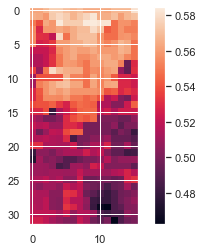

In [36]:
# convert bounds to 2D spatial array
spatial_array = mod_bounds.reshape((ngridpts[0], ngridpts[1], 5)).copy()
for i in range(1, spatial_array.shape[0], 2):  # reverse every other x slice
    spatial_array[i, :, :] = spatial_array[i, ::-1, :]
plt.figure()
plt.imshow(spatial_array[:, :, 1])
plt.colorbar()

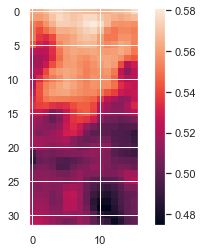

In [37]:
smoothed_spatial_bounds = np.empty(spatial_array.shape)
for i in range(5):
    smoothed_spatial_bounds[:, :, i] = convolve2d(spatial_array[:, :, i], kernel, boundary="symm", mode="same")
plt.figure()
plt.imshow(smoothed_spatial_bounds[:, :, 1])
plt.colorbar()

In [38]:
# convert bounds back to 1D snaking array
smoothed_bounds = []
for i in range(smoothed_spatial_bounds.shape[0]):
    if i % 2 == 0:
        smoothed_bounds.extend(smoothed_spatial_bounds[i, :, :].tolist())
    else:
        smoothed_bounds.extend(smoothed_spatial_bounds[i, ::-1, :].tolist())
smoothed_bounds = np.array(smoothed_bounds)
smoothed_bounds.shape

(512, 5)

In [39]:
colors5 = [0, 1, 2, 3, 4]  # ["r", "g", "b", "m ", "c"]

In [40]:
X = (col_centers_um[:, 0] / 1000).reshape(ngridpts)
Z = (col_centers_um[:, 1] / 1000).reshape(ngridpts)

In [41]:
import matplotlib as mpl

<IPython.core.display.Javascript object>


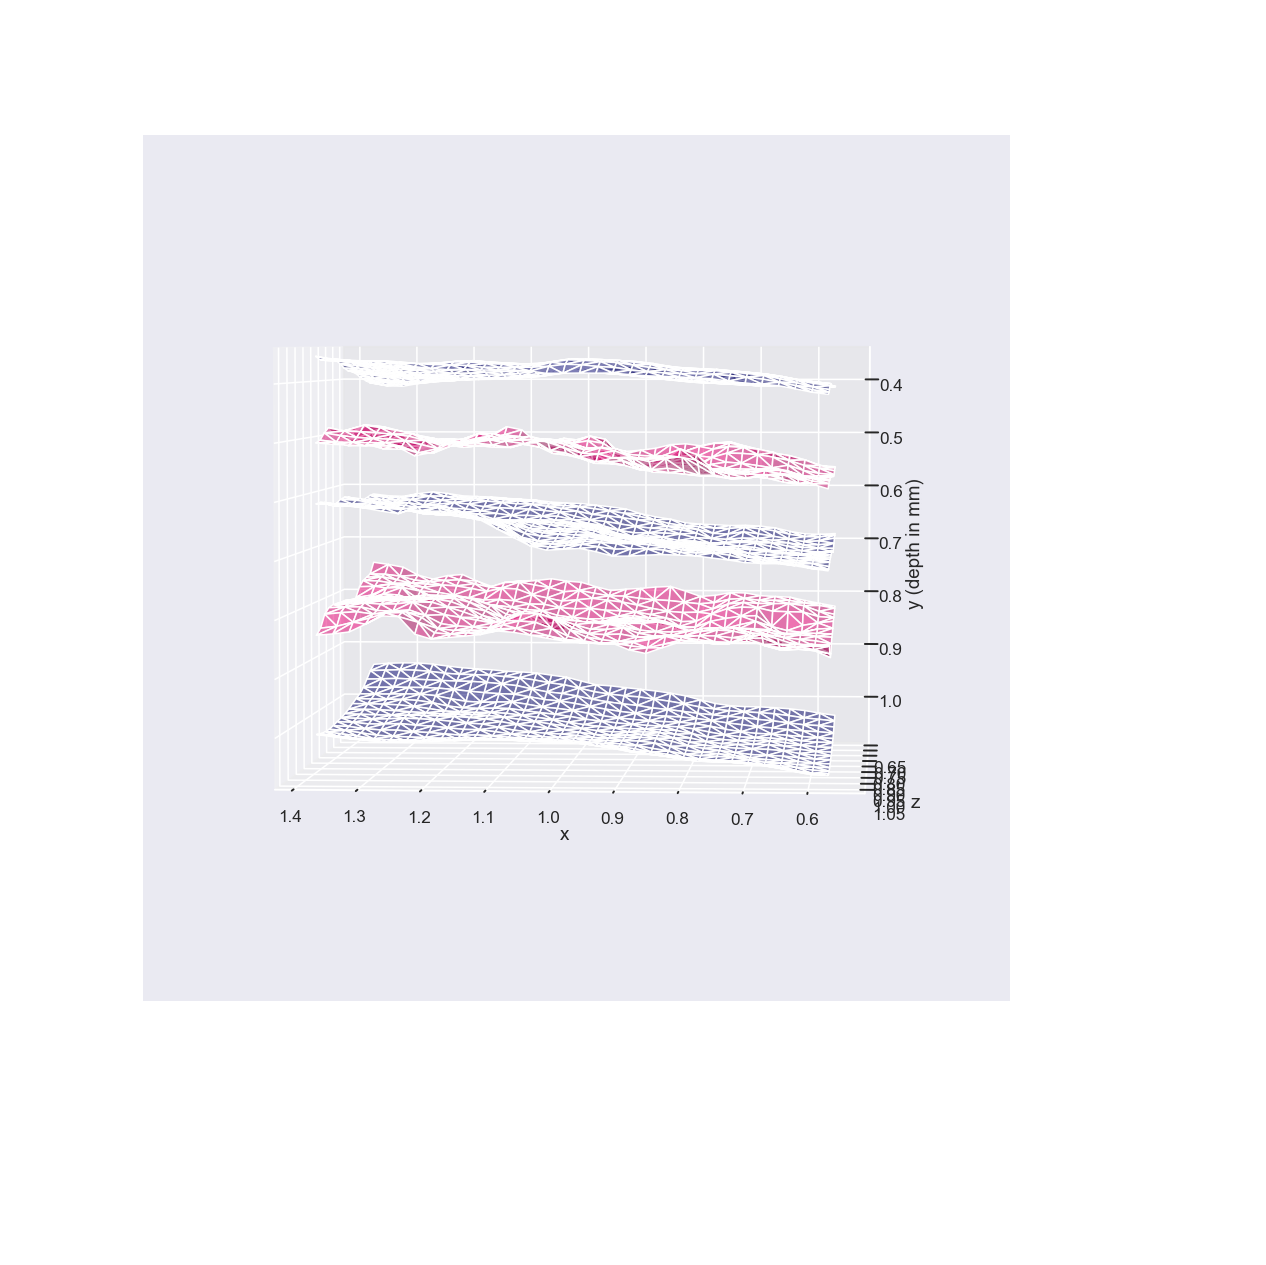

Text(0.5, 0, 'z')

In [90]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
# ax.plot_surface(X, Z, minnie_bounds[:, 0].reshape(ngridpts))
tri = mpl.tri.Triangulation(col_centers_um[:, 0] / 1000, col_centers_um[:, 1] / 1000)
for j in range(5):
    ax.plot_trisurf(col_centers_um[:, 0] / 1000, col_centers_um[:, 1] / 1000, smoothed_bounds[:, j], color=(j % 2, 0, 0.5, 0.5))
for i in []:
     ax.scatter(col_centers_um[i][0] / 1000, col_centers_um[i][1] / 1000, smoothed_bounds[i, 1], c="c", s=50)
ax.invert_zaxis()
ax.set_zlabel("y (depth in mm)")
ax.set_xlabel("x")
ax.set_ylabel("z")

In [42]:
%matplotlib inline

In [40]:
for i in range(5):
    v1_verts = np.array([tri.x, minnie_bounds[:, i], tri.y], dtype=np.float32).T * 1_000_000
    v1_faces = tri.triangles.astype(np.uint32)
    from neuroglancer_scripts.mesh import save_mesh_as_precomputed
    import os
    import json
    if not os.path.isdir('layermeshes'):
        os.makedirs('layermeshes')
    with open(f'layermeshes/{i}','wb') as fp:
        save_mesh_as_precomputed(fp, v1_verts, v1_faces)
with open(f'layermeshes/0:0','w') as fp:  # this doesn't work because 0:0 is not a valid filename in windows
    d = {'fragments':[str(i)]}
    fp.write(json.dumps(d))
        

Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32


## Make the layer boundary plot except where the distance between the layer bounds represents how many cells (of a particular type) are in that layer

In [73]:
# num_cells = dict()

In [130]:
query_type = "exc"  # one of "exc", "inh", "BC", "BPC", "MC", "NGC"

In [132]:
num_cells[query_type] = []

if query_type == "all":
    query_type_cells = auto_cells
elif query_type  == "exc":
    query_type_cells = auto_cells.query("classification_system == 'aibs_coarse_excitatory'")
elif query_type  == "exc":
    query_type_cells = auto_cells.query("classification_system == 'aibs_coarse_inhibitory'")
elif query_type in ["BC", "BPC", "NGC", "MC"]:
    query_type_cells = auto_cells.query(f"cell_type == '{query_type}'")
else:
    raise ValueError("invalid query_type. must be one of 'exc', 'inh', 'BC', 'BPC', 'MC', 'NGC'")

j = 0
for col, bounds in list(zip(cols_nm, smoothed_bounds)):
    print(j)
    bounds = bounds * 1_000_000 / resolution[1]
    
    current_bboxs = []
    current_bboxs.append(col / resolution)
    current_bboxs[-1][0][1], current_bboxs[-1][1][1] = -2 ** 30, bounds[0]
    for i in range(len(bounds) - 1):
        current_bboxs.append(col / resolution)
        current_bboxs[-1][0][1], current_bboxs[-1][1][1] = bounds[i], bounds[i + 1]
    current_bboxs.append(col / resolution)
    current_bboxs[-1][0][1], current_bboxs[-1][1][1] = bounds[-1], 2 ** 30
    
    current_num_cells = []
    for current_bbox in current_bboxs:
        current_num_cells.append(sum(query_type_cells.pt_position.apply(in_bbox, args=[current_bbox])))
        print(f"num {query_type} cells:", current_num_cells[-1])
    j += 1
    print()
    
    num_cells[query_type].append(current_num_cells)    

0
num exc cells: 1
num exc cells: 295
num exc cells: 316
num exc cells: 182
num exc cells: 391
num exc cells: 24

1
num exc cells: 1
num exc cells: 290
num exc cells: 315
num exc cells: 192
num exc cells: 398
num exc cells: 28

2
num exc cells: 3
num exc cells: 293
num exc cells: 325
num exc cells: 199
num exc cells: 394
num exc cells: 24

3
num exc cells: 2
num exc cells: 316
num exc cells: 321
num exc cells: 201
num exc cells: 401
num exc cells: 26

4
num exc cells: 2
num exc cells: 302
num exc cells: 332
num exc cells: 185
num exc cells: 410
num exc cells: 30

5
num exc cells: 2
num exc cells: 286
num exc cells: 329
num exc cells: 206
num exc cells: 383
num exc cells: 24

6
num exc cells: 0
num exc cells: 270
num exc cells: 306
num exc cells: 204
num exc cells: 379
num exc cells: 26

7
num exc cells: 0
num exc cells: 275
num exc cells: 286
num exc cells: 204
num exc cells: 371
num exc cells: 26

8
num exc cells: 1
num exc cells: 278
num exc cells: 303
num exc cells: 226
num exc cell

num exc cells: 303
num exc cells: 178
num exc cells: 351
num exc cells: 23

72
num exc cells: 3
num exc cells: 313
num exc cells: 297
num exc cells: 182
num exc cells: 366
num exc cells: 23

73
num exc cells: 3
num exc cells: 324
num exc cells: 300
num exc cells: 186
num exc cells: 364
num exc cells: 27

74
num exc cells: 2
num exc cells: 321
num exc cells: 322
num exc cells: 197
num exc cells: 371
num exc cells: 27

75
num exc cells: 2
num exc cells: 298
num exc cells: 358
num exc cells: 200
num exc cells: 379
num exc cells: 27

76
num exc cells: 2
num exc cells: 282
num exc cells: 327
num exc cells: 185
num exc cells: 364
num exc cells: 29

77
num exc cells: 2
num exc cells: 283
num exc cells: 292
num exc cells: 182
num exc cells: 359
num exc cells: 23

78
num exc cells: 2
num exc cells: 258
num exc cells: 286
num exc cells: 150
num exc cells: 335
num exc cells: 28

79
num exc cells: 5
num exc cells: 205
num exc cells: 251
num exc cells: 120
num exc cells: 236
num exc cells: 25

80
n

num exc cells: 347
num exc cells: 184
num exc cells: 319
num exc cells: 29

143
num exc cells: 0
num exc cells: 201
num exc cells: 307
num exc cells: 160
num exc cells: 238
num exc cells: 24

144
num exc cells: 1
num exc cells: 211
num exc cells: 308
num exc cells: 168
num exc cells: 239
num exc cells: 23

145
num exc cells: 0
num exc cells: 190
num exc cells: 350
num exc cells: 192
num exc cells: 327
num exc cells: 28

146
num exc cells: 0
num exc cells: 234
num exc cells: 337
num exc cells: 197
num exc cells: 354
num exc cells: 28

147
num exc cells: 0
num exc cells: 293
num exc cells: 277
num exc cells: 209
num exc cells: 351
num exc cells: 29

148
num exc cells: 0
num exc cells: 332
num exc cells: 292
num exc cells: 217
num exc cells: 369
num exc cells: 28

149
num exc cells: 0
num exc cells: 329
num exc cells: 298
num exc cells: 206
num exc cells: 373
num exc cells: 27

150
num exc cells: 2
num exc cells: 306
num exc cells: 289
num exc cells: 207
num exc cells: 371
num exc cells: 

num exc cells: 0
num exc cells: 322
num exc cells: 337
num exc cells: 198
num exc cells: 348
num exc cells: 25

214
num exc cells: 0
num exc cells: 337
num exc cells: 303
num exc cells: 198
num exc cells: 342
num exc cells: 25

215
num exc cells: 0
num exc cells: 319
num exc cells: 296
num exc cells: 207
num exc cells: 338
num exc cells: 27

216
num exc cells: 0
num exc cells: 305
num exc cells: 286
num exc cells: 201
num exc cells: 337
num exc cells: 26

217
num exc cells: 4
num exc cells: 308
num exc cells: 290
num exc cells: 196
num exc cells: 343
num exc cells: 28

218
num exc cells: 2
num exc cells: 312
num exc cells: 305
num exc cells: 206
num exc cells: 341
num exc cells: 27

219
num exc cells: 2
num exc cells: 329
num exc cells: 309
num exc cells: 220
num exc cells: 342
num exc cells: 25

220
num exc cells: 3
num exc cells: 348
num exc cells: 296
num exc cells: 252
num exc cells: 334
num exc cells: 29

221
num exc cells: 0
num exc cells: 335
num exc cells: 280
num exc cells: 25

num exc cells: 299
num exc cells: 24

284
num exc cells: 3
num exc cells: 231
num exc cells: 329
num exc cells: 245
num exc cells: 299
num exc cells: 27

285
num exc cells: 0
num exc cells: 242
num exc cells: 319
num exc cells: 219
num exc cells: 304
num exc cells: 27

286
num exc cells: 0
num exc cells: 250
num exc cells: 298
num exc cells: 221
num exc cells: 288
num exc cells: 27

287
num exc cells: 1
num exc cells: 283
num exc cells: 288
num exc cells: 198
num exc cells: 280
num exc cells: 23

288
num exc cells: 1
num exc cells: 274
num exc cells: 285
num exc cells: 191
num exc cells: 268
num exc cells: 23

289
num exc cells: 1
num exc cells: 236
num exc cells: 301
num exc cells: 205
num exc cells: 268
num exc cells: 24

290
num exc cells: 1
num exc cells: 232
num exc cells: 302
num exc cells: 220
num exc cells: 285
num exc cells: 27

291
num exc cells: 2
num exc cells: 234
num exc cells: 292
num exc cells: 233
num exc cells: 311
num exc cells: 24

292
num exc cells: 4
num exc cells

num exc cells: 270
num exc cells: 220
num exc cells: 311
num exc cells: 25

355
num exc cells: 1
num exc cells: 199
num exc cells: 321
num exc cells: 251
num exc cells: 294
num exc cells: 31

356
num exc cells: 3
num exc cells: 163
num exc cells: 360
num exc cells: 227
num exc cells: 300
num exc cells: 26

357
num exc cells: 4
num exc cells: 157
num exc cells: 352
num exc cells: 201
num exc cells: 308
num exc cells: 28

358
num exc cells: 2
num exc cells: 162
num exc cells: 324
num exc cells: 185
num exc cells: 307
num exc cells: 27

359
num exc cells: 2
num exc cells: 177
num exc cells: 291
num exc cells: 182
num exc cells: 294
num exc cells: 24

360
num exc cells: 1
num exc cells: 197
num exc cells: 288
num exc cells: 187
num exc cells: 311
num exc cells: 22

361
num exc cells: 1
num exc cells: 222
num exc cells: 296
num exc cells: 198
num exc cells: 322
num exc cells: 23

362
num exc cells: 1
num exc cells: 246
num exc cells: 304
num exc cells: 205
num exc cells: 341
num exc cells: 

num exc cells: 1
num exc cells: 164
num exc cells: 264
num exc cells: 161
num exc cells: 362
num exc cells: 24

426
num exc cells: 1
num exc cells: 163
num exc cells: 273
num exc cells: 166
num exc cells: 379
num exc cells: 30

427
num exc cells: 1
num exc cells: 163
num exc cells: 260
num exc cells: 175
num exc cells: 382
num exc cells: 27

428
num exc cells: 5
num exc cells: 167
num exc cells: 225
num exc cells: 182
num exc cells: 371
num exc cells: 28

429
num exc cells: 3
num exc cells: 182
num exc cells: 208
num exc cells: 183
num exc cells: 366
num exc cells: 26

430
num exc cells: 4
num exc cells: 194
num exc cells: 189
num exc cells: 182
num exc cells: 362
num exc cells: 28

431
num exc cells: 3
num exc cells: 186
num exc cells: 183
num exc cells: 169
num exc cells: 286
num exc cells: 23

432
num exc cells: 5
num exc cells: 194
num exc cells: 188
num exc cells: 158
num exc cells: 293
num exc cells: 23

433
num exc cells: 5
num exc cells: 206
num exc cells: 199
num exc cells: 17

num exc cells: 238
num exc cells: 24

496
num exc cells: 9
num exc cells: 193
num exc cells: 167
num exc cells: 219
num exc cells: 223
num exc cells: 22

497
num exc cells: 17
num exc cells: 180
num exc cells: 179
num exc cells: 223
num exc cells: 284
num exc cells: 24

498
num exc cells: 17
num exc cells: 176
num exc cells: 213
num exc cells: 186
num exc cells: 319
num exc cells: 24

499
num exc cells: 10
num exc cells: 181
num exc cells: 224
num exc cells: 182
num exc cells: 357
num exc cells: 25

500
num exc cells: 9
num exc cells: 211
num exc cells: 223
num exc cells: 187
num exc cells: 372
num exc cells: 27

501
num exc cells: 5
num exc cells: 211
num exc cells: 219
num exc cells: 181
num exc cells: 368
num exc cells: 24

502
num exc cells: 4
num exc cells: 201
num exc cells: 202
num exc cells: 184
num exc cells: 351
num exc cells: 25

503
num exc cells: 8
num exc cells: 209
num exc cells: 176
num exc cells: 187
num exc cells: 345
num exc cells: 24

504
num exc cells: 4
num exc ce

In [133]:
cumul_num_cells = dict()
for t in num_cells:
    counts = np.array(num_cells[t])
    cumul = np.empty(counts.shape)
    cumul[:, 0] = counts[:, 0]
    for i in range(1, 6):
        cumul[:, i]  = cumul[:, i-1] + counts[:, i]
    cumul_num_cells[t] = cumul

<IPython.core.display.Javascript object>


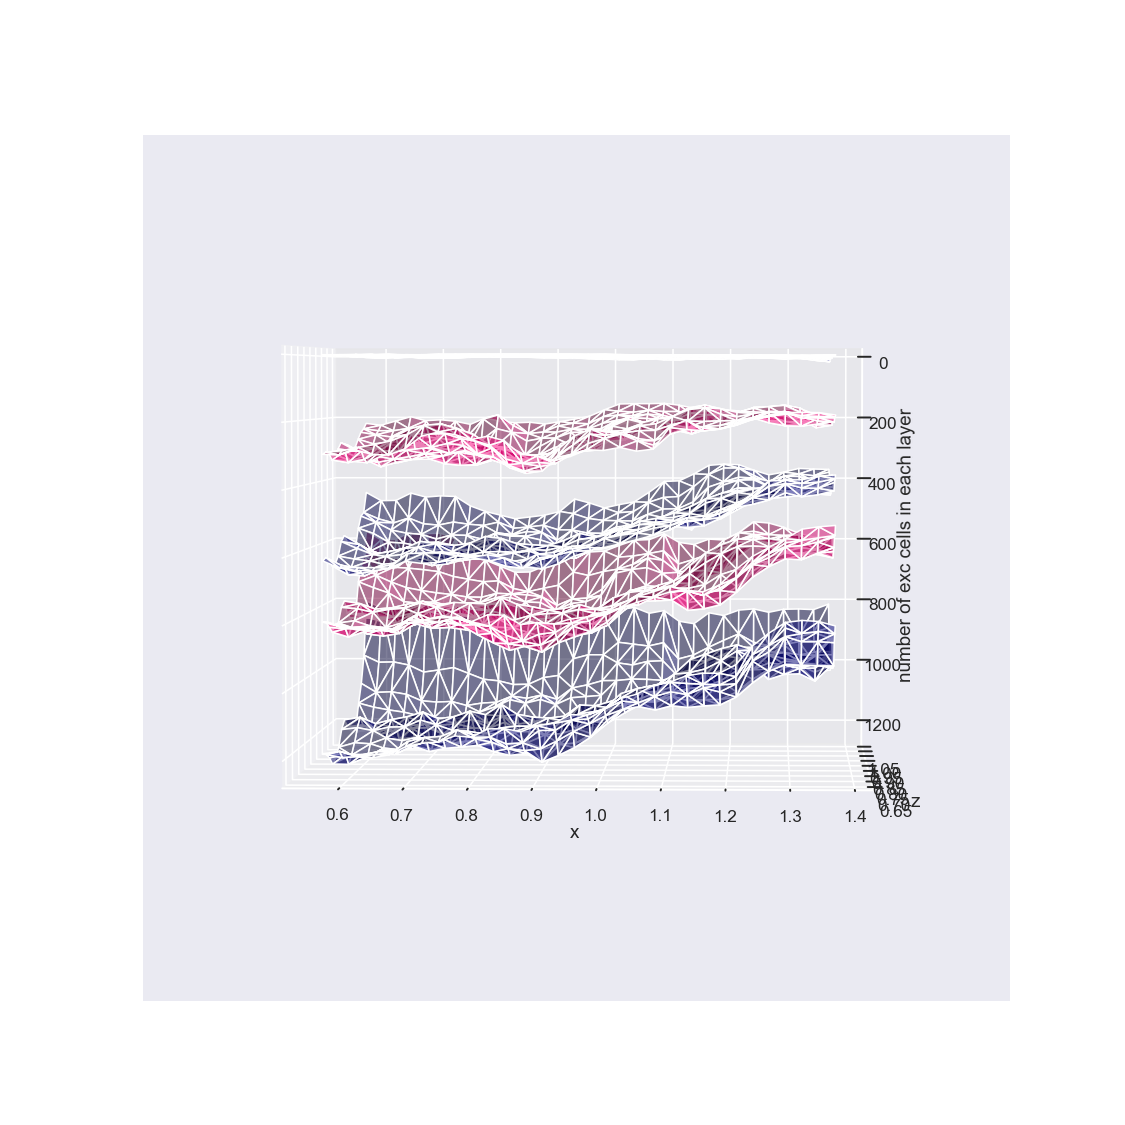

Text(0.5, 0, 'z')

In [135]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
# ax.plot_surface(X, Z, minnie_bounds[:, 0].reshape(ngridpts))
tri = mpl.tri.Triangulation(col_centers_um[:, 0] / 1000, col_centers_um[:, 1] / 1000)
for j in range(5):
    ax.plot_trisurf(col_centers_um[:, 0] / 1000, col_centers_um[:, 1] / 1000, cumul_num_cells[query_type][:, j], color=(j % 2, 0, 0.5, 0.5))
ax.invert_zaxis()
ax.set_zlabel(f"number of {query_type} cells in each layer")
ax.set_xlabel("x")
ax.set_ylabel("z")

In [136]:
fig.savefig(f"laminarPopulationCount_{query_type}.svg")

<IPython.core.display.Javascript object>


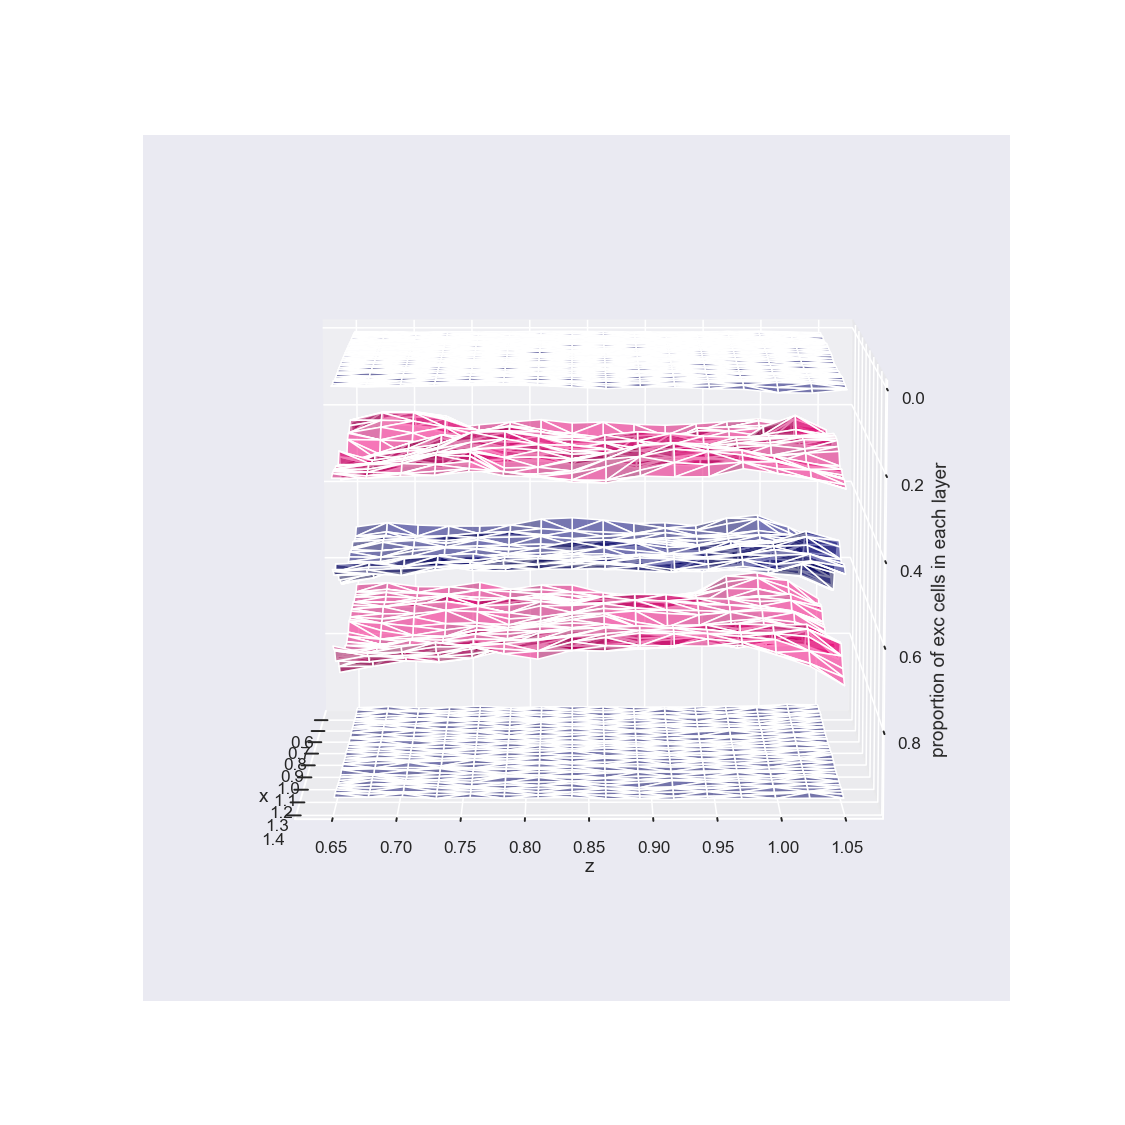

Text(0.5, 0, 'z')

In [137]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
# ax.plot_surface(X, Z, minnie_bounds[:, 0].reshape(ngridpts))
tri = mpl.tri.Triangulation(col_centers_um[:, 0] / 1000, col_centers_um[:, 1] / 1000)
for j in range(5):
    ax.plot_trisurf(col_centers_um[:, 0] / 1000, col_centers_um[:, 1] / 1000, cumul_num_cells[query_type][:, j] / cumul_num_cells[query_type][:, -1], color=(j % 2, 0, 0.5, 0.5))
ax.invert_zaxis()
ax.set_zlabel(f"proportion of {query_type} cells in each layer")
ax.set_xlabel("x")
ax.set_ylabel("z")

In [138]:
fig.savefig(f"laminarPopulationProportions_{query_type}.svg")

In [139]:
import json
with open("num_cells.json", "w") as f:
    f.write(json.dumps(num_cells))

# Test sensitivity to initial conditions

#### Results of testing sensitivity to initial conditions for the column offset +x from minnie col with x coordinate 243111 nm

When initialized using L3-L4 border = 0.54 (depth of L3-L4 border in minnie col), the result was 0.54, with a final log likelihood score of -328
    - This is even the case when use_depth = False, for which the final score was -350 (keep in mind this has one less covariate, which should increas the score)
    - 0.54, use_depth=False, features=tuple(), use_soma_vol_std=False resulted in 0.5, score was -60
    - 0.54, use_depth=False, features=("soma_volume",), use_soma_vol_std=False resulted in 0.5, score was -104


When initialized using L3-L4 border = 0.5, the result was 0.5, with a final log likelihood score of -305 (better)

## Synapses in the center of the column
#### (synapses aren't used, so you can skip these 3 cells)

In [54]:
syn_bbox = bbox.copy()
sample_width = 10_000  # nm square cross section
x_vx_width = sample_width / resolution[0]
z_vx_width = sample_width / resolution[2]
syn_bbox[0, 0] = bbox[0, 0] + (bbox[1, 0] - bbox[0, 0]) / 2
syn_bbox[1, 0] = syn_bbox[0, 0] + x_vx_width
syn_bbox[0, 2] = bbox[0, 2] + (bbox[1, 2] - bbox[0, 2]) / 2
syn_bbox[1, 2] = syn_bbox[0, 2] + z_vx_width
syn_bbox, bbox

(array([[205611.,  50000.,  21383.],
        [208111., 323500.,  21633.]]),
 array([[193111.,  50000.,  20133.],
        [218111., 323500.,  22633.]]))

In [ ]:
synapses = client.materialize.synapse_query(bounding_box=syn_bbox, bounding_box_column="ctr_pt_position", split_positions=True)

In [ ]:
synapses["pre_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.pre_pt_root_id]
synapses["post_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.post_pt_root_id]
syn_depths = synapses.ctr_pt_position_y.values * y_resolution / 1_000_000
syn_depths_by_pre = dict((t, []) for t in cell_types)
syn_depths_by_post = dict((t, []) for t in cell_types)
for i in synapses.index:
    # pre
    syn = synapses.loc[i]
    if syn.pre_type in ctype_to_layer.keys():
        syn_depths_by_pre["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.pre_type in syn_depths_by_pre.keys():
        syn_depths_by_pre[syn.pre_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    
    # post
    if syn.post_type in ctype_to_layer.keys():
        syn_depths_by_post["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.post_type in syn_depths_by_post.keys():
        syn_depths_by_post[syn.post_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
for t in syn_depths_by_pre:
    syn_depths_by_pre[t] = np.array(syn_depths_by_pre[t])
for t in syn_depths_by_post:
    syn_depths_by_post[t] = np.array(syn_depths_by_post[t])

synapses

## Get features by depth

In [39]:
# cross sectional area to be layered
xarea = resolution[0] * resolution[2] * (bbox[1][0] - bbox[0][0]) * (bbox[1][2] - bbox[0][2]) / 1_000_000 ** 2

In [40]:
# min is pia border (with L1) and max is white matter border (with L6)
min_y = min(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
max_y = max(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
min_y, max_y

(0.358016, 1.086656)

### Sort the dataframe of cells by depth to make getting features by depth way faster

In [41]:
auto_col_cells = auto_col_cells.sort_values(axis="index", by="pt_position", key=lambda xs: pd.Series([x[1] for x in xs]))

def get_cutoff_idx(df, y, prev_cutoff_idx, position_col="pt_position"):
    """efficiently find the first index after prev_cutoff_idx where position[1] is greater than y"""
    i = prev_cutoff_idx
    if i >= len(df):
        return i
    while df.iloc[i][position_col][1] * y_resolution / 1_000_000 < y:
        i += 1
        if i >= len(df):
            return i
    return i  # new_cutoff_idx

In [42]:
exc_soma_densities = []
inh_soma_densities = []
synapse_densities = []
# syn_densities_by_pre = dict((t, []) for t in syn_depths_by_pre.keys())
# syn_densities_by_post = dict((t, []) for t in syn_depths_by_post.keys())
p_type = dict((t, []) for t in ["23", "4", "5", "6"])
p_inh_subclass = dict((t, []) for t in ["BC", "BPC", "MC", "NGC"])
exc_soma_features_by_depth = dict((f, []) for f in features)
inh_soma_features_by_depth = dict((f, []) for f in features)
soma_features_by_depth = dict((f, []) for f in features)
exc_soma_vol_std_by_depth = []
exc_soma_depths = []
bin_centers = []

depths = np.arange(min_y, max_y, step_size)
bin_centers = depths + step_size // 2
prev_cutoff_idx = 0
for curr_y in depths:
    # first index where pt_position[1] is greater than curr_y + bin_width 
    cutoff_idx = get_cutoff_idx(auto_col_cells, curr_y + bin_width, prev_cutoff_idx)
    lower_cutoff_idx = get_cutoff_idx(auto_col_cells, curr_y, prev_cutoff_idx)
    
    current_cells = auto_col_cells.iloc[lower_cutoff_idx:cutoff_idx]
    current_exc_cells = current_cells.query("classification_system == 'aibs_coarse_excitatory'")
    current_inh_cells = current_cells.query("classification_system == 'aibs_coarse_inhibitory'")
    
    for f in features:
        soma_features_by_depth[f].append(current_cells[f].mean())
        exc_soma_features_by_depth[f].append(current_exc_cells[f].mean())
        inh_soma_features_by_depth[f].append(current_inh_cells[f].mean())
    exc_soma_vol_std_by_depth.append(current_exc_cells["soma_volume"].std())
    mean_pos = current_exc_cells["pt_position"].mean()
    exc_soma_depths.append((mean_pos[1] if mean_pos is not np.nan else np.nan))
                          
    for t in p_type:
        p_type[t].append(0)
    for i in current_exc_cells.index:
        if current_exc_cells.loc[i].cell_type != "Unsure":
            p_type[ctype_to_layer[current_exc_cells.loc[i].cell_type]][-1] += 1 / len(current_exc_cells) if len(current_exc_cells) > 0 else np.nan
    exc_soma_densities.append(len(current_exc_cells))
    
    inh_soma_densities.append(len(current_inh_cells))
    for t in p_inh_subclass:
        p_inh_subclass[t].append(0)
    for i in current_inh_cells.index:
        if current_inh_cells.loc[i].cell_type != "Unsure":
            p_inh_subclass[current_inh_cells.loc[i].cell_type][-1] += 1 / len(current_inh_cells) if len(current_inh_cells) > 0 else np.nan
            
    # # this is still slow
    # synapse_densities.append(sum((curr_y <= syn_depths) & (syn_depths < curr_y + bin_width)))
    # for t in syn_densities_by_pre.keys():
    #     syn_densities_by_pre[t].append(sum((curr_y <= syn_depths_by_pre[t]) & (syn_depths_by_pre[t] < curr_y + bin_width)))
    # for t in syn_densities_by_post.keys():
    #     syn_densities_by_post[t].append(sum((curr_y <= syn_depths_by_post[t]) & (syn_depths_by_post[t] < curr_y + bin_width)))
    
    prev_cutoff_idx = lower_cutoff_idx
exc_soma_densities = np.array(exc_soma_densities, dtype=float) / (bin_width * xarea)  # per mm^3
inh_soma_densities = np.array(inh_soma_densities, dtype=float) / (bin_width * xarea)
# synapse_densities = np.array(synapse_densities, dtype=float) / (bin_width * xarea)
for t in p_type:
    p_type[t] = np.array(p_type[t])
for t in p_inh_subclass:
    p_inh_subclass[t] = np.array(p_inh_subclass[t])
# for t in syn_densities_by_pre:
#     syn_densities_by_pre[t] = np.array(syn_densities_by_pre[t]) / (bin_width * xarea)
# for t in syn_depths_by_post:
#     syn_densities_by_post[t] = np.array(syn_densities_by_post[t]) / (bin_width * xarea)

In [43]:
def clean_nans(x, normalize=False):
    """linearly interpolates to fill in nans
    normalizing subtracts mean and divides by std
    """
    cleaned = np.array(x)
    mask = np.isfinite(cleaned)
    cleaned = np.interp(np.arange(len(cleaned)), np.arange(len(cleaned))[mask], cleaned[mask])
    if normalize:
        cleaned -= cleaned.mean()
        cleaned /= cleaned.std()
    return cleaned

In [44]:
exc_features_df = pd.DataFrame(exc_soma_features_by_depth)
exc_features_df["soma_density"] = exc_soma_densities
exc_features_df["soma_vol_std"] = exc_soma_vol_std_by_depth
for col in exc_features_df.columns:
    exc_features_df[col] = clean_nans(exc_features_df[col], normalize=True)
exc_features_df

,soma_volume,n_soma_syn,nucleus_volume,nucleus_fract_fold,sum_proc_sdf,nucleus_to_soma,soma_density,soma_vol_std
0,-0.361149,1.056956,-0.482037,-1.307653,0.073811,-0.010727,-2.459284,-0.510483
1,0.072851,1.352864,0.024528,-1.119267,0.488860,-0.483754,-2.333443,-0.372161
2,-0.496472,1.149017,-0.671847,-0.777104,-0.160848,0.201132,-2.239062,-0.200191
3,-0.561166,1.066820,-0.658463,-0.773483,-0.160015,0.407955,-2.144682,-0.353769
4,-0.508450,1.066203,-0.562224,-0.787083,0.121552,0.415325,-2.018841,-0.239253
...,...,...,...,...,...,...,...,...
141,0.513799,-1.936269,0.798473,0.064612,-0.453667,-0.511446,-2.050301,-0.416314
142,0.892940,-2.020489,0.647528,-1.164225,-0.009569,-1.856223,-2.333443,-0.119303
143,0.892940,-2.020489,0.647528,-1.164225,-0.009569,-1.856223,-2.490744,-0.119303
144,0.892940,-2.020489,0.647528,-1.164225,-0.009569,-1.856223,-2.490744,-0.119303


### PCA on the features to remove correlations

(<matplotlib.image.AxesImage at 0x13d72405a20>,
 <matplotlib.colorbar.Colorbar at 0x13d7243f390>)

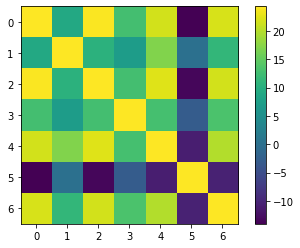

In [72]:
X = exc_features_df.values.T
Xc = X - np.mean(X, axis=1, keepdims=True)  # mean subtract data first
cov = Xc @ Xc.T / (X.shape[0] - 1)  # covariance
plt.imshow(cov), plt.colorbar()

In [73]:
variance, V = np.linalg.eig(cov)
idxs = np.argsort(-variance)
V = V[:, idxs]
variance = variance[idxs]
explained_variance = [sum(variance[:i+1]) / sum(variance) for i in range(len(variance))]

Text(0, 0.5, 'explained variance')

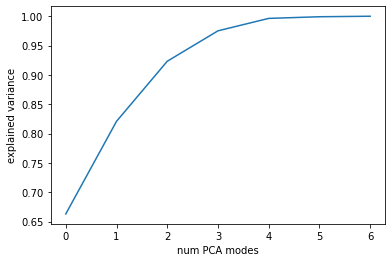

In [74]:
plt.plot(explained_variance)
plt.xlabel("num PCA modes")
plt.ylabel("explained variance")

In [75]:
# Yc is the projection of Xc onto the principal components 
Yc = V[:, :7].T @ Xc
Yc.shape

(7, 146)

### get inhibitory cell types for column to verify our boundaries
#### also excitatory subclasses

In [58]:
# cell_subtypes = pd.read_excel("CellTypesMinnieColumn.xlsx", sheet_name="csv", usecols=["Unnamed: 0", "Type-Nuno"])
# cell_subtypes.rename({"Unnamed: 0": "pt_position", "Type-Nuno": "subtype"}, axis=1, inplace=True)
# # convert the string position into a list of ints
# cell_subtypes["pt_position"] = [list(map(int, cell_subtypes["pt_position"].iloc[i][1:-1].split(", "))) for i in range(len(cell_subtypes))]
# cell_subtypes["mm_depth"] = [cell_subtypes["pt_position"].iloc[i][1] * 4 / 1_000_000 for i in range(len(cell_subtypes))]

In [59]:
auto_col_cells["mm_depth"] = [auto_col_cells.pt_position.iloc[i][1] * 4 / 1_000_000 for i in range(len(auto_col_cells))]

In [60]:
# possible_subtypes = ['Type-L03-3P-XXX', 'Type01-L03-3P-PRV', 'Type02-L03-3P-PRV',
#        'Type02-L04-3P-PRV', 'Type04-L04-3P-PRV', 'Type05-L04-4P-PRV',
#        'Type06-B45-4P-PRV', 'Type06-L05-4P-PRV', 'Type07-L04-4P-PRV',
#        'Type08-B45-3P-PRV', 'Type09-L05-4P-PRV', 'Type11-L05-3P-PRV',
#        'Type10-L05-PT-PRV', 'Type23-L05-PT-PRV', 'Type12-L05-PT-PRV',
#        'Type13-L05-IT-PRV', 'Type14-L05-NP-PRV', 'Type15-L06-6P-PRV',
#        'Type16-L06-XX-CCK', 'Type17-L03-3P-VIP', 'Type22-L03-3P-VIP',
#        'Type19-B45-4P-VIP', 'Type20-L05-XX-VIP', 'Type21-L06-6P-VIP',
#        'Type18-L03-3P-VIP', 'Type3-L03-3P-PRV', 'Type4-L04-3P-PRV',
#        'Type4-L06-6P-PRV']
possible_exc_subclasses = ["23P", "4P", "5P_IT", "5P_NP", "5P_PT", "6CT", "6IT"]
# len(possible_subtypes)

## Plot!

In [61]:
# colors = ["tab:" + s for s in ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]]
colors = get_cmap("tab20").colors[::2] + get_cmap("tab20b").colors[::2]
len(colors)

20

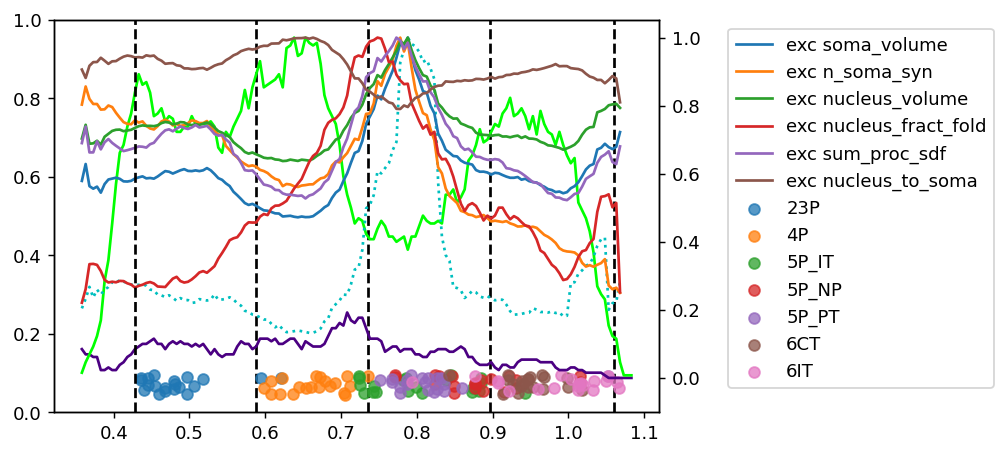

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=130)
ax2 = ax.twinx()
ax2.plot(bin_centers, inh_soma_densities / np.nanmax(exc_soma_densities), c="indigo") #, label="inh soma density")
ax2.plot(bin_centers, exc_soma_densities / np.nanmax(exc_soma_densities), c="lime") #, label="exc soma density")
ax2.plot(bin_centers, exc_soma_vol_std_by_depth / np.nanmax(exc_soma_vol_std_by_depth), color="c", linestyle=":") #, label="exc soma_volume std")

# for i in range(Yc.shape[0]):
#     c = colors[i % len(colors)]
#     ax2.plot(bin_centers, Yc[i, :], color=c, label=f"PCA mode {i}")
#     ax2.plot(bin_centers, model_means[:, i], linestyle="-.", color=c )
#     ax2.fill_between(bin_centers, model_means[:, i] - model_stds[:, i], model_means[:, i] + model_stds[:, i], edgecolor="none", facecolor=c, alpha=0.2)
#     
for i, f in enumerate(features):
    c = colors[i % len(colors)]
    ax2.plot(bin_centers, exc_soma_features_by_depth[f] / np.nanmax(exc_soma_features_by_depth[f]), linestyle="-", color=c, label="exc " + f)
#     ax2.plot(bin_centers, normalized_smooth_exc_features[f], linestyle=":", label="exc fit " + f)
#     ax2.plot(bin_centers, inh_soma_features_by_depth[f] / max(inh_soma_features_by_depth[f]), linestyle="-", label="inh " + f)
#     ax2.plot(bin_centers, soma_features_by_depth[f] / max(soma_features_by_depth[f]), linestyle="-", label=f)

# ax.plot(bin_centers, synapse_densities, label="syn")
# for t in syn_densities_by_pre:
#     ax2.plot(bin_centers, syn_densities_by_pre[t], label=t)
# for t in syn_densities_by_post:
#     ax2.plot(bin_centers, syn_densities_by_post[t], label=t)
# for i, t in enumerate(possible_subtypes):
#     cur = cell_subtypes.query(f"subtype == '{t}'").mm_depth.values
#     plt.scatter(cur, np.random.normal(-0.03, 0.025, len(cur)), color=colors[i], alpha=0.75, label=t)
for i, t in enumerate(possible_exc_subclasses): #[(0, "5P_NP")]
    cur = auto_col_cells.query(f"cell_type == '{t}'").sample(20, replace=True).mm_depth.values
    plt.scatter(cur, np.random.uniform(-0.05, 0.01, len(cur)), color=colors[i], alpha=0.75, label=t)

    
ax2.axvline(labels[0], linestyle="--", color="k") #, label="manual")
for lab in labels[1:]:
    ax.axvline(lab, linestyle="--", color="k")
# ax2.axvline(bounds[0], linestyle="--", color="blue") #, label="automatic")
# for bound in bounds[1:]:
#     ax2.axvline(bound, linestyle="--", color="blue")
# ax.legend(bbox_to_anchor=[1.1, 1])
ax2.legend(bbox_to_anchor=[1.1, 1])
ax2.set_xlabel("depth ($mm$)")
# ax.set_ylabel("soma density (per $mm^{3}$)")
# ax2.set_ylabel("synapse density (per $mm^3$)")
plt.show()

In [110]:
auto_col_cells.query(f"cell_type == '5P_NP' and mm_depth > 0.850516").pt_root_id.values

array([864691136273892365, 864691135644655343, 864691135467814540,
       864691136084257900, 864691136108768952, 864691135122533159,
       864691135355173327, 864691135939606529, 864691136023967801,
       864691136922980324], dtype=int64)

# Hidden Markov Model implementation

In [129]:
from hmmlearn import hmm

In [130]:
# hmm.GaussianHMM?

In [131]:
model = hmm.GaussianHMM(n_components=6, covariance_type="diag", init_params="", params="mc", n_iter=1)
# the model starts in the first state, and there is 0 probability of starting elsewhere
model.startprob_ = np.zeros(model.n_components)
model.startprob_[0] = 1
p = 0.04
transition_probs = np.full(model.n_components - 1, p)
stay_probs = np.full(model.n_components, 1-p)
stay_probs[-1] = 1  # nothing deeper than white matter
model.transmat_ = np.diag(stay_probs) + np.diag(transition_probs, k=1)
model.transmat_

array([[0.96, 0.04, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.96, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [84]:
use_depth = True
varis = Yc.T
if use_depth:
    varis = np.hstack([varis, clean_nans(exc_soma_depths, normalize=True).reshape(-1, 1)])

In [85]:
# initialize means and variances
nf = varis.shape[1]
default_bounds = np.array([0.3, 0.400516, 0.555516, 0.700516, 0.830516, 1.010516, 1.1])  # from HMM trained on 2 PCA modes in column
model.means_ = np.zeros((model.n_components, nf))
covars = np.ones((model.n_components, nf))
for i in range(model.n_components):
    idxs = (default_bounds[i] <= bin_centers) & (bin_centers < default_bounds[i + 1])
    model.means_[i, :] = varis[idxs, :].mean(axis=0)
    covars[i, :] = varis[idxs, :].var(axis=0) + 1e-10
model.covars_ = covars
    
if use_depth:
    depth_centers = model.means_[:, -1]  # to help reduce major errors, these will be the means for the depth emissions

observables, hidden_states = model.sample(101)

In [86]:
prev_score = -1
score = model.score(varis)
max_iters = 100
tol = 0.001
i = 0
while abs(score - prev_score) > tol and i < max_iters:
    model.fit(varis)
    prev_score = score
    score = model.score(varis)
    print(score)
    i += 1
    # model.means_[[0, -1]] = 0  # means for L1 and WM exc soma density should be 0 (I should instead not use the HMM for this, just a threshold)
    if use_depth:
        # each iteration re-fix the "target" mean depth to the center of each default layer
        # so the model can't be terribly wrong
        model.means_[:, -1] = depth_centers
    print("after correction:", model.score(varis))
    
if abs(score - prev_score) > tol:
    raise ValueError("Did not converge")

165.32624782004982
after correction: 165.18214730289375
168.73830377766504
after correction: 168.30291248217404
171.06824724139142
after correction: 170.40313683472667
172.10775423746318
after correction: 171.36787393330548
172.36794433198722
after correction: 171.62093886479636
172.44973100991783
after correction: 171.71026124201668
172.49701048967364
after correction: 171.76610173848988
172.53179405619176
after correction: 171.80783691428132
172.55904392173935
after correction: 171.84031112916296
172.580709726691
after correction: 171.86583073573613
172.59799943585963
after correction: 171.8859658780533
172.6118256882085
after correction: 171.90191021468507
172.6229088966645
after correction: 171.91458687118714
172.63181795286212
after correction: 171.92470794077636
172.63899993282897
after correction: 171.93282152135006
172.64480551959912
after correction: 171.93935006398888
172.64951015756245
after correction: 171.94462054946774
172.65333093655588
after correction: 171.948887532174

In [87]:
layers = model.predict(varis).tolist()

In [88]:
str(layers)

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]'

In [89]:
bounds = []
for i in range(1, model.n_components):
    idx = layers.index(i)
    bounds.append((bin_centers[idx] + bin_centers[idx-1]) / 2)
    print(bin_centers[idx])
bounds = np.array(bounds)

0.40301600000000004
0.5580160000000002
0.6980160000000003
0.8480160000000004
1.0130160000000006


In [90]:
model_means = np.array([model.means_[l] for l in layers])
model_stds = np.array([np.diagonal(np.sqrt(model.covars_[l])) for l in layers])
model_means, model_stds

(array([[ 0.01291211, -0.70117581,  1.74964165, ..., -0.03515673,
          0.06093547, -1.58781314],
        [ 0.01291211, -0.70117581,  1.74964165, ..., -0.03515673,
          0.06093547, -1.58781314],
        [ 0.01291211, -0.70117581,  1.74964165, ..., -0.03515673,
          0.06093547, -1.58781314],
        ...,
        [ 0.04665182, -2.4646269 , -0.31864476, ..., -0.0451766 ,
         -0.07037827,  1.52698845],
        [ 0.04665182, -2.4646269 , -0.31864476, ..., -0.0451766 ,
         -0.07037827,  1.52698845],
        [ 0.04665182, -2.4646269 , -0.31864476, ..., -0.0451766 ,
         -0.07037827,  1.52698845]]),
 array([[0.27786775, 0.38025133, 0.24051822, ..., 0.09035585, 0.06516923,
         0.06713758],
        [0.27786775, 0.38025133, 0.24051822, ..., 0.09035585, 0.06516923,
         0.06713758],
        [0.27786775, 0.38025133, 0.24051822, ..., 0.09035585, 0.06516923,
         0.06713758],
        ...,
        [0.65507607, 0.75186692, 0.42318014, ..., 0.13478792, 0.11520517

In [91]:
posteriors = model.predict_proba(varis)

# Plot model results!

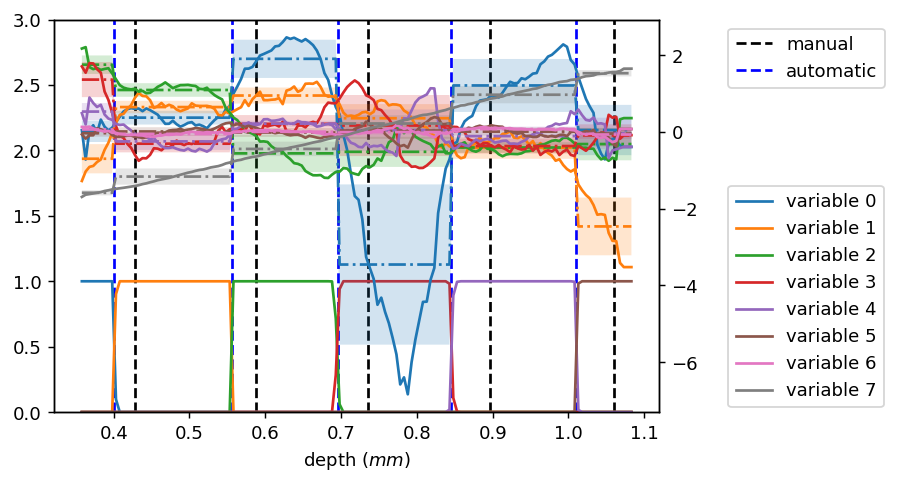

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=130)
ax2 = ax.twinx()

for i in range(varis.shape[1]):
    c = colors[i % len(colors)]
    ax2.plot(bin_centers, varis[:, i], color=c, label=f"variable {i}")
    ax2.plot(bin_centers, model_means[:, i], linestyle="-.", color=c )
    ax2.fill_between(bin_centers, model_means[:, i] - model_stds[:, i], model_means[:, i] + model_stds[:, i], edgecolor="none", facecolor=c, alpha=0.2)
#     
# for i, f in enumerate(features):
#     c = colors[i % len(colors)]
#     ax2.plot(bin_centers, exc_soma_features_by_depth[f] / np.nanmax(exc_soma_features_by_depth[f]), linestyle="-", color=c, label="exc " + f)
#     ax2.plot(bin_centers, model_means[:, i + 2], linestyle="-.", color=c, label="exc "+ f + " model mean")
#     ax2.fill_between(bin_centers, model_means[:, i+2] - model_stds[:, i+2], model_means[:, i+2] + model_stds[:, i+2], edgecolor="none", facecolor=c, alpha=0.2)
#     ax2.plot(bin_centers, normalized_smooth_exc_features[f], linestyle=":", label="exc fit " + f)
#     ax2.plot(bin_centers, inh_soma_features_by_depth[f] / max(inh_soma_features_by_depth[f]), linestyle="-", label="inh " + f)
#     ax2.plot(bin_centers, soma_features_by_depth[f] / max(soma_features_by_depth[f]), linestyle="-", label=f)

# ax.plot(bin_centers, synapse_densities, label="syn")
# for t in syn_densities_by_pre:
#     ax2.plot(bin_centers, syn_densities_by_pre[t], label=t)
# for t in syn_densities_by_post:
#     ax2.plot(bin_centers, syn_densities_by_post[t], label=t)
    
ax.axvline(labels[0], linestyle="--", color="k", label="manual")
for lab in labels[1:]:
    ax.axvline(lab, linestyle="--", color="k")
ax.axvline(bounds[0], linestyle="--", color="blue", label="automatic")
for bound in bounds[1:]:
    ax.axvline(bound, linestyle="--", color="blue")
ax.plot(bin_centers, posteriors)
ax.legend(bbox_to_anchor=[1.1, 1])
ax2.legend(bbox_to_anchor=[1.1, 0.6])
ax.set_xlabel("depth ($mm$)")
ax.set_ylim([0, 3])
# ax.set_ylabel("soma density (per $mm^{3}$)")
# ax2.set_ylabel("synapse density (per $mm^3$)")
plt.show()

### predicted layer boundaries as a function of number of PCA modes used

In [93]:
bounds

array([0.400516, 0.555516, 0.695516, 0.845516, 1.010516])

In [730]:
array([0.400516, 0.555516, 0.690516, 0.850516, 1.035516])  # all 7 PCA modes

array([0.400516, 0.555516, 0.690516, 0.850516, 1.035516])

In [716]:
array([0.400516, 0.555516, 0.695516, 0.845516, 1.035516])  # 6 PCA modes

array([0.400516, 0.555516, 0.695516, 0.845516, 1.035516])

In [674]:
array([0.400516, 0.555516, 0.700516, 0.825516, 1.035516])  # 3 PCA modes

array([0.400516, 0.555516, 0.700516, 0.825516, 1.035516])

In [ ]:
array([0.400516, 0.555516, 0.700516, 0.830516, 1.010516])  # 2 PCA modes

In [ ]:
array([0.400516, 0.555516, 0.690516, 0.855516, 1.035516])  # 1 PCA mode

# Sum of magnitudes of fft-smoothed derivatives

In [233]:
from scipy import fft

In [419]:
freq_cutoff = 0.05
cleaned = clean_nans(exc_soma_densities, divide_by_max=True)
e_fft = fft.fft(cleaned)
freqs = fft.fftfreq(len(exc_soma_densities))
mask = abs(freqs) < freq_cutoff
e_fft *= mask  # remove high frequency content (details/noise)
e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
normalized_smooth_exc_densities = np.real(fft.ifft(e_fft))
smooth_exc_soma_densities_deriv = np.real(fft.ifft(e_fft_prime))

normalized_smooth_exc_features = dict() 
smooth_exc_feature_derivs = dict()
for f in features:
    cleaned = clean_nans(exc_soma_features_by_depth[f], divide_by_max=True)
    e_fft = fft.fft(cleaned)
    freqs = fft.fftfreq(len(cleaned))
    mask = abs(freqs) < freq_cutoff
    e_fft *= mask  # remove high frequency content (details/noise)
    e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
    normalized_smooth_exc_features[f] = np.real(fft.ifft(e_fft))
    smooth_exc_feature_derivs[f] = np.real(fft.ifft(e_fft_prime))

In [421]:
transitionness = sum(np.abs(smooth_exc_feature_derivs[f]) for f in features) + smooth_exc_soma_densities_deriv

## another way to visualize

No handles with labels found to put in legend.


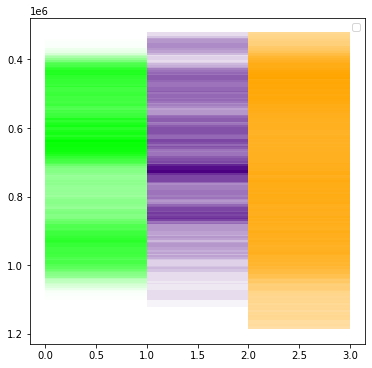

In [113]:
# todo fill with alpha = density
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(bin_centers)):
        bin_start, bin_end = bin_centers[i] - step_size // 2, bin_centers[i] + step_size // 2
        ax.fill_between([0, 1], [bin_start]*2, [bin_end]*2, alpha=exc_soma_densities[i] / max(exc_soma_densities), color="lime", edgecolor=None)
        ax.fill_between([1, 2], [bin_start]*2, [bin_end]*2, alpha=inh_soma_densities[i] / max(inh_soma_densities), color="indigo", edgecolor=None)
    
ax.invert_yaxis()
ax.legend()
plt.show()

## Ideas:
Use synapse_query(bounding_box) to get synapse density too (and stratify by cell type)

Use inhibitory cell subclass densities (do these use depth info? yes, so don't)

Use *excitatory* soma features (they're much less noisy than inhibitory/combined features) and look for significant and steep changes in these features with depth by using the fft-smoothed version of each feature (as a function of depth) and then take its derivative (in fourier domain). The magnitude of the derivative of the smoothed function indicates how much of a transition zone it is according to that feature, and if we take the product of these derivative magnitudes we should see peaks at the layer borders.

In [103]:
soma_features.columns

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')

In [160]:
bounds_by_x = dict()
bounds_by_x["use_depth_changing_default"] = np.array([[0.3983493333333334, 0.5555160000000001, 0.7005160000000004, 0.8455160000000004, 1.0505160000000004], [0.3971826666666667, 0.5455160000000001, 0.7005160000000004, 0.8405160000000005, 1.0511410000000005], [0.39179200000000003, 0.5442920000000002, 0.7042920000000004, 0.8442920000000005, 1.0489348571428578], [0.39250628571428575, 0.5442920000000002, 0.6942920000000004, 0.8442920000000005, 1.0457920000000005], [0.39261133333333337, 0.5480280000000002, 0.6880280000000003, 0.8430280000000004, 1.0388613333333339], [0.39052800000000004, 0.5480280000000002, 0.6880280000000003, 0.8180280000000004, 1.0305280000000006], [0.38261133333333336, 0.5480280000000002, 0.6830280000000003, 0.8180280000000004, 1.0294168888888895], [0.37214800000000003, 0.5451480000000002, 0.6851480000000003, 0.8051480000000004, 1.0290765714285721], [0.3724312727272728, 0.5422040000000001, 0.6722040000000002, 0.8272040000000005, 1.0318468571428576], [0.3705413333333334, 0.5447080000000002, 0.6647080000000003, 0.8147080000000004, 1.0309580000000007], [0.37105415384615387, 0.5447080000000002, 0.6647080000000003, 0.8147080000000004, 1.0257794285714292], [0.37720800000000004, 0.5397080000000002, 0.6547080000000003, 0.8297080000000004, 1.0244807272727279], [0.3773926666666667, 0.5444760000000002, 0.6544760000000003, 0.8294760000000004, 1.020547428571429], [0.37788509090909095, 0.5044760000000001, 0.6594760000000003, 0.8294760000000004, 1.0159760000000007], [0.38147600000000004, 0.5044760000000001, 0.6594760000000003, 0.8294760000000004, 1.0119760000000007], [0.38197600000000004, 0.5044760000000001, 0.6494760000000003, 0.8294760000000004, 1.0086426666666672], [0.3850036363636364, 0.5061400000000001, 0.6461400000000003, 0.8011400000000004, 1.0023900000000006], [0.38864000000000004, 0.5061400000000001, 0.6461400000000003, 0.7861400000000004, 0.9996400000000006], [0.38454909090909095, 0.5061400000000001, 0.6411400000000003, 0.7811400000000004, 0.9923900000000005], [0.3872763636363637, 0.5011400000000001, 0.6361400000000003, 0.7761400000000004, 0.9953066666666672], [0.3867716923076923, 0.49696400000000013, 0.6369640000000003, 0.7769640000000004, 0.9969640000000006], [0.3867973333333334, 0.5019640000000001, 0.6319640000000002, 0.7869640000000004, 0.9957140000000005], [0.3861946666666667, 0.5020280000000001, 0.6270280000000003, 0.7870280000000004, 0.9961946666666672], [0.38452800000000004, 0.5120280000000001, 0.6170280000000002, 0.7870280000000004, 0.9953613333333339], [0.3797653333333334, 0.5139320000000002, 0.6139320000000003, 0.7889320000000004, 0.9904320000000005], [0.37337600000000004, 0.5158760000000002, 0.6108760000000002, 0.7808760000000003, 0.9876617142857149], [0.376309090909091, 0.5179000000000002, 0.6079000000000003, 0.7929000000000004, 0.9904000000000006]])
bounds_by_x["soma_vol_density"] = np.array([np.array([0.39834933, 0.555516  , 0.700516  , 0.865516  , 1.050516  ]), np.array([0.39718267, 0.555516  , 0.700516  , 0.845516  , 1.051141  ]), np.array([0.391792  , 0.549292  , 0.704292  , 0.844292  , 1.04893486]), np.array([0.39250629, 0.544292  , 0.694292  , 0.844292  , 1.045792  ]), np.array([0.39261133, 0.548028  , 0.693028  , 0.848028  , 1.03886133]), np.array([0.390528, 0.543028, 0.683028, 0.858028, 1.030528]), np.array([0.38261133, 0.548028  , 0.683028  , 0.848028  , 1.02941689]), np.array([0.372148  , 0.545148  , 0.685148  , 0.840148  , 1.02907657]), np.array([0.37243127, 0.537204  , 0.682204  , 0.842204  , 1.03184686]), np.array([0.37054133, 0.539708  , 0.674708  , 0.829708  , 1.030958  ]), np.array([0.37105415, 0.539708  , 0.664708  , 0.834708  , 1.02577943]), np.array([0.377208  , 0.514708  , 0.659708  , 0.839708  , 1.02448073]), np.array([0.37739267, 0.494476  , 0.664476  , 0.829476  , 1.02054743]), np.array([0.37788509, 0.494476  , 0.664476  , 0.829476  , 1.015976  ]), np.array([0.381476, 0.499476, 0.659476, 0.829476, 1.011976]), np.array([0.381976  , 0.504476  , 0.644476  , 0.829476  , 1.00864267]), np.array([0.38500364, 0.50114   , 0.64614   , 0.82614   , 1.00239   ]), np.array([0.38864, 0.50614, 0.64614, 0.81614, 0.99964]), np.array([0.38454909, 0.50114   , 0.64614   , 0.79114   , 0.99239   ]), np.array([0.38727636, 0.50114   , 0.63614   , 0.78614   , 0.99530667]), np.array([0.38677169, 0.496964  , 0.636964  , 0.781964  , 0.996964  ]), np.array([0.38679733, 0.506964  , 0.631964  , 0.801964  , 0.995714  ]), np.array([0.38619467, 0.507028  , 0.632028  , 0.777028  , 0.99619467]), np.array([0.384528  , 0.517028  , 0.617028  , 0.787028  , 0.99536133]), np.array([0.37976533, 0.513932  , 0.618932  , 0.778932  , 0.990432  ]), np.array([0.373376  , 0.510876  , 0.615876  , 0.775876  , 0.98766171]), np.array([0.37630909, 0.5129    , 0.6079    , 0.7829    , 0.9904    ])])
bounds_by_x["soma_vol_std_density"] = np.array([[0.3983493333333334, 0.5605160000000002, 0.7005160000000004, 0.8605160000000005, 1.0505160000000004], [0.3971826666666667, 0.5555160000000001, 0.7005160000000004, 0.8455160000000004, 1.0511410000000005], [0.39179200000000003, 0.5492920000000001, 0.7042920000000004, 0.8442920000000005, 1.0489348571428578], [0.39250628571428575, 0.5442920000000002, 0.6942920000000004, 0.8442920000000005, 1.0457920000000005], [0.39261133333333337, 0.5480280000000002, 0.6930280000000003, 0.8280280000000004, 1.0388613333333339], [0.39052800000000004, 0.5530280000000002, 0.6880280000000003, 0.8180280000000004, 1.0305280000000006], [0.38261133333333336, 0.5480280000000002, 0.6830280000000003, 0.8180280000000004, 1.0294168888888895], [0.37214800000000003, 0.5601480000000002, 0.6801480000000003, 0.8351480000000004, 1.0290765714285721], [0.3724312727272728, 0.5472040000000002, 0.6722040000000002, 0.8322040000000004, 1.0318468571428576], [0.3705413333333334, 0.5447080000000002, 0.6647080000000003, 0.8297080000000004, 1.0309580000000007], [0.37105415384615387, 0.5447080000000002, 0.6647080000000003, 0.8297080000000004, 1.0257794285714292], [0.37720800000000004, 0.5147080000000002, 0.6597080000000003, 0.8347080000000004, 1.0244807272727279], [0.3773926666666667, 0.49947600000000014, 0.6594760000000003, 0.8344760000000004, 1.020547428571429], [0.37788509090909095, 0.49947600000000014, 0.6644760000000003, 0.8294760000000004, 1.0159760000000007], [0.38147600000000004, 0.5044760000000001, 0.6594760000000003, 0.8344760000000004, 1.0119760000000007], [0.38197600000000004, 0.5044760000000001, 0.6444760000000003, 0.8294760000000004, 1.0086426666666672], [0.3850036363636364, 0.5011400000000001, 0.6461400000000003, 0.8011400000000004, 1.0023900000000006], [0.38864000000000004, 0.5011400000000001, 0.6461400000000003, 0.7911400000000004, 0.9996400000000006], [0.38454909090909095, 0.5011400000000001, 0.6461400000000003, 0.7861400000000004, 0.9923900000000005], [0.3872763636363637, 0.5011400000000001, 0.6361400000000003, 0.7861400000000004, 0.9953066666666672], [0.3867716923076923, 0.49696400000000013, 0.6369640000000003, 0.7819640000000003, 0.9969640000000006], [0.3867973333333334, 0.5069640000000002, 0.6369640000000003, 0.7869640000000004, 0.9957140000000005], [0.3861946666666667, 0.5070280000000001, 0.6270280000000003, 0.7870280000000004, 0.9961946666666672], [0.38452800000000004, 0.5120280000000001, 0.6170280000000002, 0.7870280000000004, 0.9953613333333339], [0.3797653333333334, 0.5189320000000002, 0.6089320000000003, 0.7889320000000004, 0.9904320000000005], [0.37337600000000004, 0.5208760000000001, 0.6058760000000003, 0.7808760000000003, 0.9876617142857149], [0.376309090909091, 0.5179000000000002, 0.6079000000000003, 0.7929000000000004, 0.9904000000000006]])

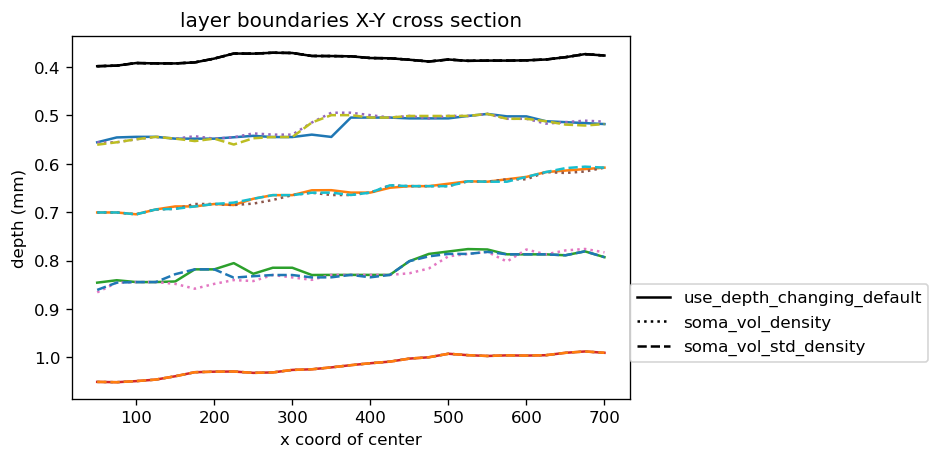

In [166]:
fig, ax = plt.subplots(dpi=120)
linestyles = ["-", ":", "--", "-."]
for i, n in enumerate(bounds_by_x):
    ax.plot(range(50, 725, 25), bounds_by_x[n][:, 0], color="k", linestyle=linestyles[i % len(linestyles)], label=n)
    for j in range(1, bounds_by_x[n].shape[1]):
        ax.plot(range(50, 725, 25), bounds_by_x[n][:, j], linestyle=linestyles[i % len(linestyles)])
ax.set_xlabel("x coord of center")
ax.set_ylabel("depth (mm)")
ax.invert_yaxis()
ax.set_title("layer boundaries X-Y cross section")
ax.legend(loc=[1, 0.1])

In [191]:
np.nonzero(exc_soma_densities > 50_000)[0][-1]

138